In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns


In [11]:
def mark_bad_channels_interactive(raw, initial_bads=None):
    """
    Helper function to interactively mark bad channels.
    
    Parameters:
    -----------
    raw : mne.io.Raw
        The raw EEG data
    initial_bads : list, optional
        List of channel names to initially mark as bad
    
    Returns:
    --------
    raw : mne.io.Raw
        Raw object with bad channels marked
    """
    if initial_bads:
        raw.info['bads'] = initial_bads
    
    # Plot for interactive bad channel selection
    print("Mark bad channels by clicking on them in the plot.")
    print("Close the window when done.")
    raw.plot(duration=10, n_channels=30, scalings='auto', 
             title='Click on channels to mark as bad', block=True)
    
    print(f"\nMarked bad channels: {raw.info['bads']}")
    return raw


def create_qc_comparison_report(raw, save_path=None):
    """
    Create a QC report comparing data before and after bad channel marking.
    
    Parameters:
    -----------
    raw : mne.io.Raw
        The raw EEG data with bad channels marked
    save_path : str, optional
        Path to save the QC report figure
    """
    
    # Get good and bad channels
    bad_channels = raw.info['bads']
    good_channels = [ch for ch in raw.ch_names if ch not in bad_channels]
    good_indices = mne.pick_channels(raw.ch_names, good_channels)
    
    # Set up the figure
    fig = plt.figure(figsize=(20, 16))
    gs = GridSpec(4, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # Get basic info
    sfreq = raw.info['sfreq']
    n_total_channels = len(raw.ch_names)
    n_good_channels = len(good_channels)
    n_bad_channels = len(bad_channels)
    duration = raw.times[-1]
    
    # Title
    fig.suptitle(f'EEG Quality Control - After Bad Channel Marking\n'
                 f'Total Channels: {n_total_channels} | Good: {n_good_channels} | Bad: {n_bad_channels}\n'
                 f'Bad Channels: {", ".join(bad_channels) if bad_channels else "None"}',
                 fontsize=16, fontweight='bold')
    
    # Get data
    all_data = raw.get_data()
    good_data = all_data[good_indices, :]
    
    # 1. Raw data plot - GOOD CHANNELS ONLY
    ax1 = fig.add_subplot(gs[0, :])
    plot_duration = min(10, duration)
    start, stop = 0, int(plot_duration * sfreq)
    
    # Plot good channels
    offset = np.max(np.abs(good_data[:, start:stop])) * 0.5
    times = raw.times[start:stop]
    
    for i, ch_idx in enumerate(good_indices):
        ch_name = raw.ch_names[ch_idx]
        ax1.plot(times, good_data[i, start:stop] - i * offset, 
                linewidth=0.5, alpha=0.8, color='blue')
    
    ax1.set_ylabel('Channels')
    ax1.set_xlabel('Time (s)')
    ax1.set_title(f'Cleaned Data - Good Channels Only (First {plot_duration:.0f} seconds)')
    ax1.set_yticks(-np.arange(n_good_channels) * offset)
    ax1.set_yticklabels(good_channels)
    ax1.grid(True, alpha=0.3)
    ax1.invert_yaxis()
    
    # 2. Before/After variance comparison
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Calculate variance for all channels
    all_var = np.var(all_data, axis=1)
    
    # Create bar plot
    x = np.arange(n_total_channels)
    colors = ['red' if ch in bad_channels else 'blue' for ch in raw.ch_names]
    alphas = [0.3 if ch in bad_channels else 0.8 for ch in raw.ch_names]
    
    bars = ax2.bar(x, all_var, color=colors, alpha=0.8)
    for bar, alpha in zip(bars, alphas):
        bar.set_alpha(alpha)
    
    ax2.set_xlabel('Channel Index')
    ax2.set_ylabel('Variance (μV²)')
    ax2.set_title('Channel Variance (Red = Bad Channels)')
    ax2.grid(True, alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='blue', alpha=0.8, label='Good channels'),
                      Patch(facecolor='red', alpha=0.3, label='Bad channels')]
    ax2.legend(handles=legend_elements)
    
    # 3. PSD comparison
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Compute PSD for good channels only
    psd_good, freqs = mne.time_frequency.psd_array_welch(
        good_data, sfreq=sfreq, fmin=0.5, fmax=50, n_fft=int(sfreq*2)
    )
    
    # If there are bad channels, compute their PSD for comparison
    if bad_channels:
        bad_indices = mne.pick_channels(raw.ch_names, bad_channels)
        bad_data = all_data[bad_indices, :]
        psd_bad, _ = mne.time_frequency.psd_array_welch(
            bad_data, sfreq=sfreq, fmin=0.5, fmax=50, n_fft=int(sfreq*2)
        )
        
        # Plot bad channels PSD
        mean_psd_bad = np.mean(10 * np.log10(psd_bad), axis=0)
        ax3.plot(freqs, mean_psd_bad, 'r-', alpha=0.5, linewidth=2, 
                label=f'Bad channels (n={n_bad_channels})')
    
    # Plot good channels PSD
    mean_psd_good = np.mean(10 * np.log10(psd_good), axis=0)
    std_psd_good = np.std(10 * np.log10(psd_good), axis=0)
    
    ax3.plot(freqs, mean_psd_good, 'b-', linewidth=2, label=f'Good channels (n={n_good_channels})')
    ax3.fill_between(freqs, mean_psd_good - std_psd_good, mean_psd_good + std_psd_good, 
                     alpha=0.3, color='blue')
    
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Power (dB)')
    ax3.set_title('Power Spectral Density Comparison')
    ax3.set_xlim(0, 50)
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # 4. Good channels correlation matrix
    ax4 = fig.add_subplot(gs[1, 2])
    
    # Compute correlation for good channels only
    subset_good_data = good_data[:, ::10]
    corr_matrix_good = np.corrcoef(subset_good_data)
    
    im = ax4.imshow(corr_matrix_good, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    ax4.set_xlabel('Good Channel Index')
    ax4.set_ylabel('Good Channel Index')
    ax4.set_title('Correlation Matrix - Good Channels Only')
    plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)
    
    # 5. Amplitude distribution comparison
    ax5 = fig.add_subplot(gs[2, 0])
    
    # Sample data
    sample_good = good_data[:, ::100].flatten()
    
    # Plot histogram for good channels
    ax5.hist(sample_good, bins=100, alpha=0.7, color='blue', density=True, 
             label='Good channels')
    
    # If there are bad channels, plot their distribution
    if bad_channels:
        sample_bad = bad_data[:, ::100].flatten()
        ax5.hist(sample_bad, bins=100, alpha=0.5, color='red', density=True, 
                label='Bad channels')
    
    ax5.set_xlabel('Amplitude (μV)')
    ax5.set_ylabel('Density')
    ax5.set_title('Amplitude Distribution Comparison')
    ax5.grid(True, alpha=0.3)
    ax5.legend()
    
    # 6. Time-based RMS - good channels only
    ax6 = fig.add_subplot(gs[2, 1])
    
    window_size = int(sfreq)  # 1-second windows
    n_windows = good_data.shape[1] // window_size
    rms_over_time = []
    time_points = []
    
    for i in range(n_windows):
        start_idx = i * window_size
        end_idx = (i + 1) * window_size
        window_data = good_data[:, start_idx:end_idx]
        rms = np.sqrt(np.mean(window_data**2, axis=1))
        rms_over_time.append(np.mean(rms))
        time_points.append(raw.times[start_idx])
    
    ax6.plot(time_points, rms_over_time, 'b-', linewidth=2)
    ax6.set_xlabel('Time (s)')
    ax6.set_ylabel('Mean RMS (μV)')
    ax6.set_title('Signal RMS Over Time - Good Channels Only')
    ax6.grid(True, alpha=0.3)
    
    # 7. Signal quality metrics
    ax7 = fig.add_subplot(gs[2, 2])
    
    # Calculate SNR estimate (signal power / noise power)
    # Using 1-4 Hz as noise estimate and 8-13 Hz as signal estimate
    psd_good_full, freqs_full = mne.time_frequency.psd_array_welch(
        good_data, sfreq=sfreq, fmin=0.1, fmax=50, n_fft=int(sfreq*4)
    )
    
    noise_band = (freqs_full >= 1) & (freqs_full <= 4)
    signal_band = (freqs_full >= 8) & (freqs_full <= 13)
    
    noise_power = np.mean(psd_good_full[:, noise_band], axis=1)
    signal_power = np.mean(psd_good_full[:, signal_band], axis=1)
    snr_per_channel = 10 * np.log10(signal_power / noise_power)
    
    ax7.bar(range(len(snr_per_channel)), snr_per_channel, color='green', alpha=0.7)
    ax7.set_xlabel('Good Channel Index')
    ax7.set_ylabel('SNR (dB)')
    ax7.set_title('Signal-to-Noise Ratio per Channel\n(Alpha/Low-frequency ratio)')
    ax7.grid(True, alpha=0.3)
    ax7.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    # 8. Bad segments on good channels
    ax8 = fig.add_subplot(gs[3, :2])
    
    # Detect high amplitude segments in good channels only
    threshold = np.percentile(np.abs(good_data), 99.9)
    bad_segments = np.any(np.abs(good_data) > threshold, axis=0)
    
    ax8.plot(raw.times[:len(bad_segments)], np.max(np.abs(good_data), axis=0), 
             'b-', linewidth=0.5, alpha=0.7)
    ax8.fill_between(raw.times[:len(bad_segments)], 0, 
                     np.max(np.abs(good_data), axis=0) * bad_segments,
                     color='red', alpha=0.5, label='High amplitude segments')
    ax8.set_xlabel('Time (s)')
    ax8.set_ylabel('Max Absolute Amplitude (μV)')
    ax8.set_title('Potential Bad Segments - Good Channels Only')
    ax8.grid(True, alpha=0.3)
    ax8.legend()
    
    # 9. Summary statistics
    ax9 = fig.add_subplot(gs[3, 2])
    ax9.axis('off')
    
    # Calculate statistics
    mean_snr = np.mean(snr_per_channel)
    stats_text = f"""
    Data Quality Summary:
    
    Channel Statistics:
    Total channels: {n_total_channels}
    Good channels: {n_good_channels}
    Bad channels: {n_bad_channels}
    
    Good Channels Signal Stats:
    Mean amplitude: {np.mean(good_data):.2f} μV
    Std amplitude: {np.std(good_data):.2f} μV
    Min amplitude: {np.min(good_data):.2f} μV
    Max amplitude: {np.max(good_data):.2f} μV
    
    Quality Metrics:
    Mean SNR: {mean_snr:.2f} dB
    Bad segments: {np.sum(bad_segments)/len(bad_segments)*100:.1f}%
    Mean correlation: {np.mean(corr_matrix_good[np.triu_indices_from(corr_matrix_good, k=1)]):.3f}
    
    Improvement:
    Variance reduction: {(1 - np.var(good_data)/np.var(all_data))*100:.1f}%
    """
    
    ax9.text(0.1, 0.9, stats_text, transform=ax9.transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"QC report saved to: {save_path}")
    
    return fig, {
        'bad_channels': bad_channels,
        'good_channels': good_channels,
        'mean_snr': mean_snr,
        'bad_segments_ratio': np.sum(bad_segments)/len(bad_segments),
        'variance_reduction': (1 - np.var(good_data)/np.var(all_data))*100
    }


Extracting EDF parameters from /Users/cccbauer/Documents/GitHub/rt-BPD/analysis/BVAnalyzer/export/sub-rtbpd003_ses-nf2_task_feedback_run-01_cleaned.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 44999  =      0.000 ...   179.996 secs...
Option 1: Interactive bad channel marking
Mark bad channels by clicking on them in the plot.
Close the window when done.
Using pyopengl with version 3.1.7
Channels marked as bad:
['ECG']

Marked bad channels: ['ECG']
Effective window size : 2.000 (s)
Effective window size : 2.000 (s)
Effective window size : 4.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/var/folders/9y/y6xh07m50kb7jt9df0d41trr0000gp/T/ipykernel_21409/1304765023.py:283: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


QC report saved to: eeg_qc_after_bad_channels.png

QUALITY CONTROL SUMMARY
Bad channels marked: ['ECG']
Good channels remaining: 31
Mean SNR (alpha/low-freq): -6.08 dB
Bad segments: 2.26%
Variance reduction: 84.1%


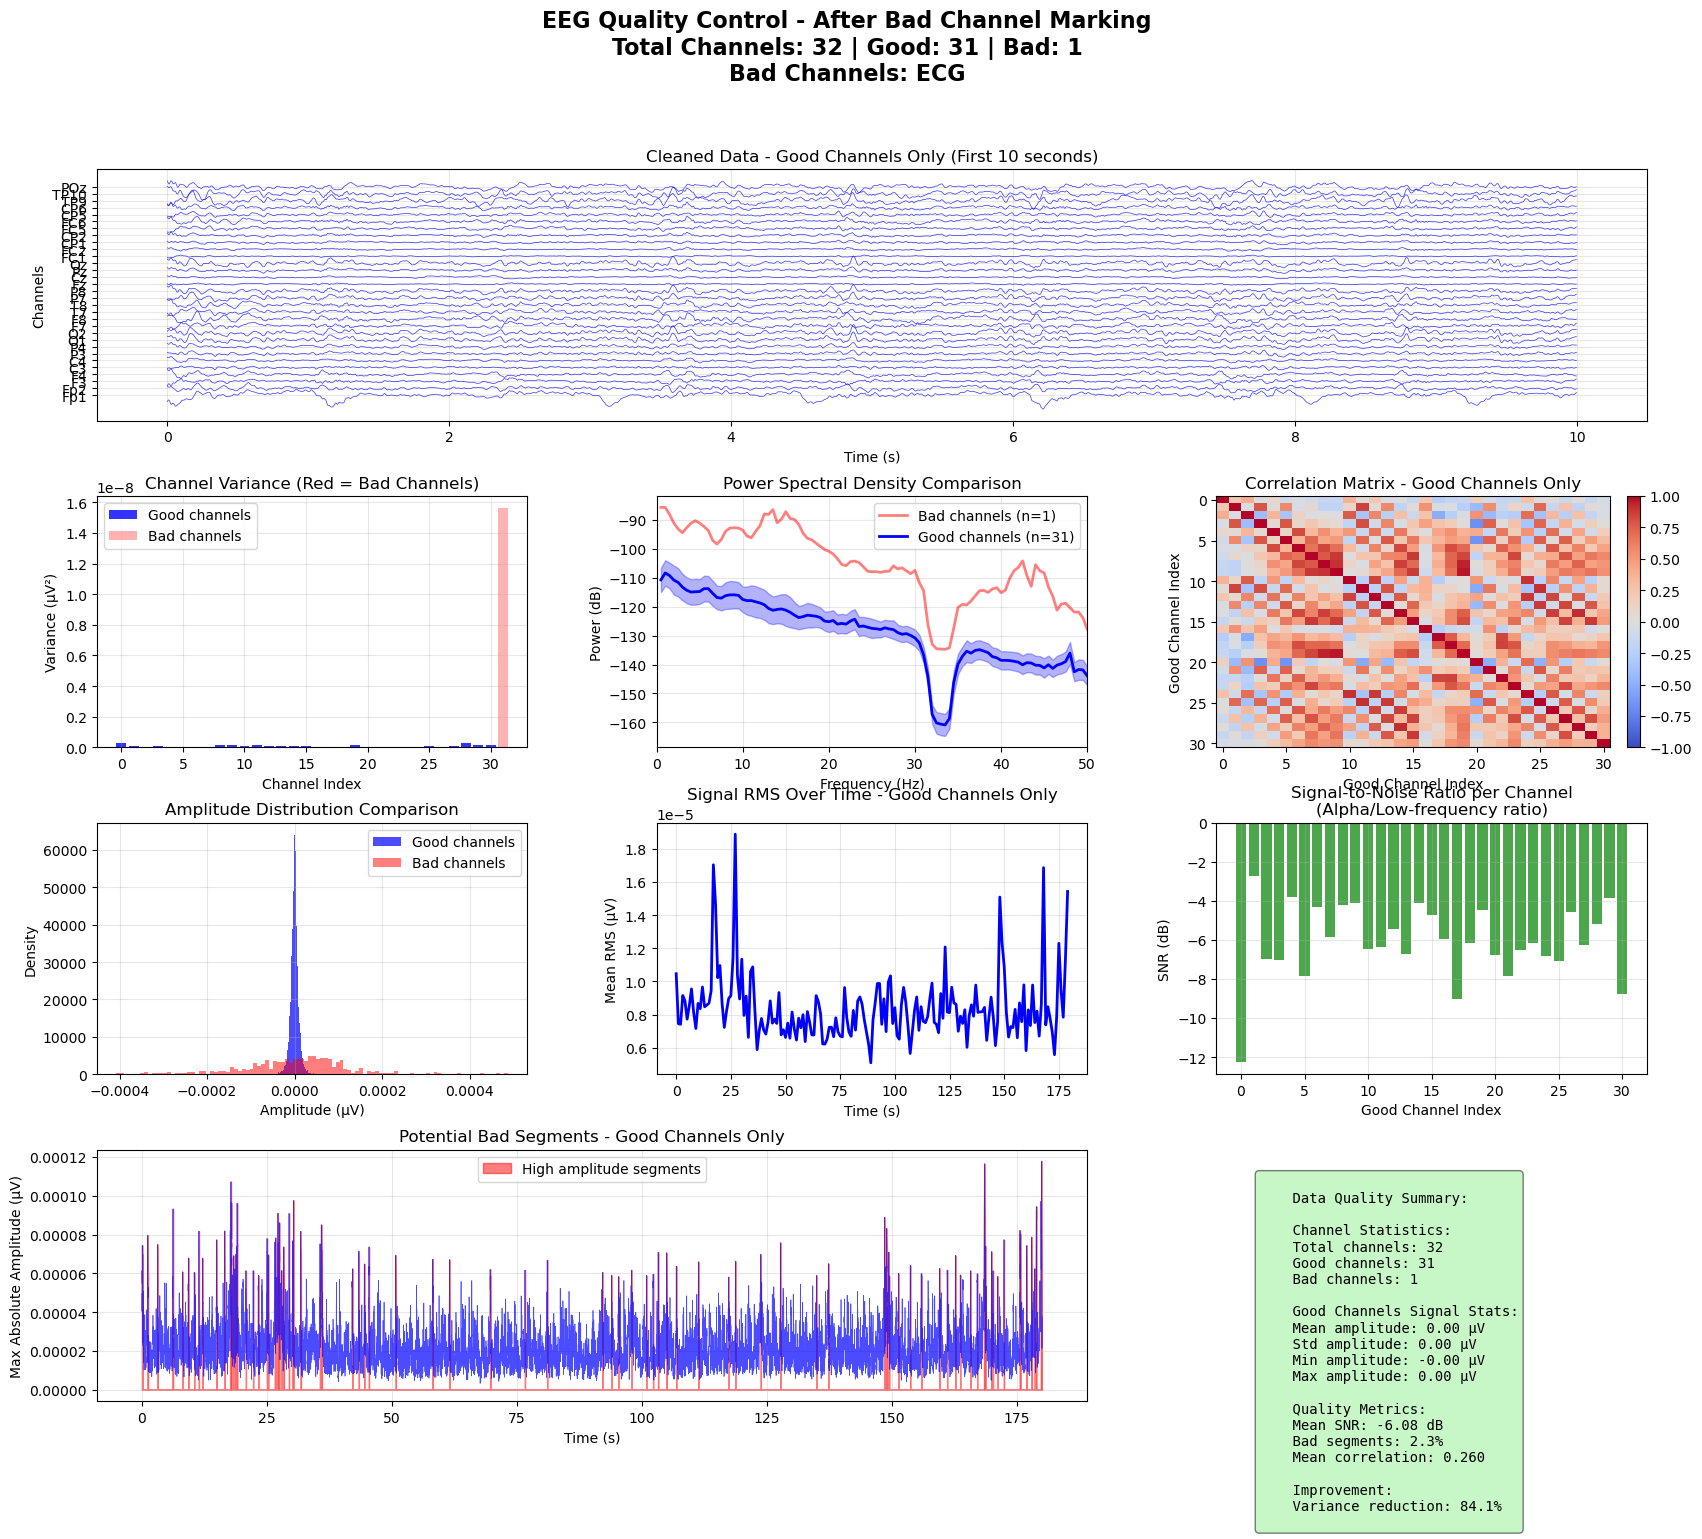

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Overwriting existing file.
Writing /Users/cccbauer/Documents/GitHub/rt-BPD/analysis/MNE/cleaned_data.fif
Closing /Users/cccbauer/Documents/GitHub/rt-BPD/analysis/MNE/cleaned_data.fif
[done]


/var/folders/9y/y6xh07m50kb7jt9df0d41trr0000gp/T/ipykernel_21409/2671409109.py:38: RuntimeWarning: This filename (/Users/cccbauer/Documents/GitHub/rt-BPD/analysis/MNE/cleaned_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save('cleaned_data.fif', overwrite=True)


[PosixPath('/Users/cccbauer/Documents/GitHub/rt-BPD/analysis/MNE/cleaned_data.fif')]

In [12]:


# Usage example:

# Load your data
raw = mne.io.read_raw_edf('../BVAnalyzer/export/sub-rtbpd003_ses-nf2_task_feedback_run-01_cleaned.edf', preload=True)

# Option 1: Mark bad channels interactively
print("Option 1: Interactive bad channel marking")
raw = mark_bad_channels_interactive(raw)

# Option 2: Mark bad channels programmatically
# (uncomment and modify as needed)
# raw.info['bads'] = ['Fp1', 'T6']  # Example channel names

# Option 3: Use automatic bad channel detection
# (uncomment to use)
# from mne.preprocessing import find_bad_channels_maxwell
# auto_bads = mne.preprocessing.find_bad_channels_maxwell(raw)
# raw.info['bads'] = auto_bads

# Create the comparison QC report
fig, qc_stats = create_qc_comparison_report(raw, save_path='eeg_qc_after_bad_channels.png')

# Print summary
print("\n" + "="*50)
print("QUALITY CONTROL SUMMARY")
print("="*50)
print(f"Bad channels marked: {qc_stats['bad_channels']}")
print(f"Good channels remaining: {len(qc_stats['good_channels'])}")
print(f"Mean SNR (alpha/low-freq): {qc_stats['mean_snr']:.2f} dB")
print(f"Bad segments: {qc_stats['bad_segments_ratio']*100:.2f}%")
print(f"Variance reduction: {qc_stats['variance_reduction']:.1f}%")

# Show the plot
plt.show()

# Create a clean copy with bad channels removed
raw_clean = raw.copy().pick_channels(qc_stats['good_channels'])
raw_clean.save('cleaned_data.fif', overwrite=True)

In [14]:
import pandas as pd
pda = pd.read_csv('../murfi/sub-rtBPD003_ses-nf_task-feedback_run-01_PDA.csv')
pda_signal = pda.iloc[:, 0].values  # adjust based on column structure
pda_signal

array([ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      , -0.020739,  0.289791,  0.022934,  0.175495,
        0.124757,  0.175281,  0.106063,  0.014794,  0.11553 ,  0.227791,
        0.142647,  0.03228 ,  0.032175,  0.008961, -0.001549, -0.086719,
       -0.198549, -0.034456,  0.004653,  0.031492,  0.275361,  0.194273,
        0.240349,  0.141674,  0.108914,  0.000638,  0.120705,  0.11529 ,
        0.060699,  0.022516,  0.058842,  0.122358, -0.041444, -0.006015,
       -0.019878,  0.021121,  0.014684,  0.044464,  0.048689,  0.047782,
        0.10379 ,  0.101758,  0.037175,  0.069467,  0.095984,  0.168834,
        0.115294,  0.178553,  0.044025,  0.081509,  0.077418,  0.141709,
        0.11388 ,  0.093542,  0.034966, -0.044102, -0.062494, -0.077436,
        0.094607,  0.197714,  0.172179,  0.179277,  0.170454,  0.047362,
        0.058982,  0.018535,  0.078351,  0.023586, -0.091607, -0.182139,
       -0.312861, -0.294898, -0.049351,  0.198593, 

## Step 1: PDA Upsampling to 4 Hz

In [40]:
from scipy.interpolate import interp1d

# Original PDA: every 1.2 seconds
original_fs = 1 / 1.2  # ~0.833 Hz
pda_time_orig = np.arange(len(pda_signal)) / original_fs

# Target time: 4 Hz over full EEG duration
target_fs = 4.0
duration_sec = raw.times[-1]
target_time = np.arange(0, duration_sec, 1/target_fs)

# Interpolate PDA to 4 Hz
interp_func = interp1d(pda_time_orig, pda_signal, kind='cubic', fill_value='extrapolate')
pda_resampled = interp_func(target_time)

# Normalize
pda_resampled_z = (pda_resampled - np.mean(pda_resampled)) / np.std(pda_resampled)


## Step 2: EEG time-frequency decomposition (via Stockwell or STFT) and Downsample EEG Power to 4 Hz


Cleaned EEG data shape: (31, 45000)
Number of good EEG channels: 31
Sampling frequency: 250.0 Hz
STFT window: 1.0 seconds (250 samples)
STFT step: 62.5 samples (16.0 ms)

STFT output shape: (31, 126, 727)
Power matrix shape: (727, 31, 126)
Time bins: 727 (from 0.00 to 180.05 seconds)
Frequency bins: 126 (from 0.00 to 125.00 Hz)


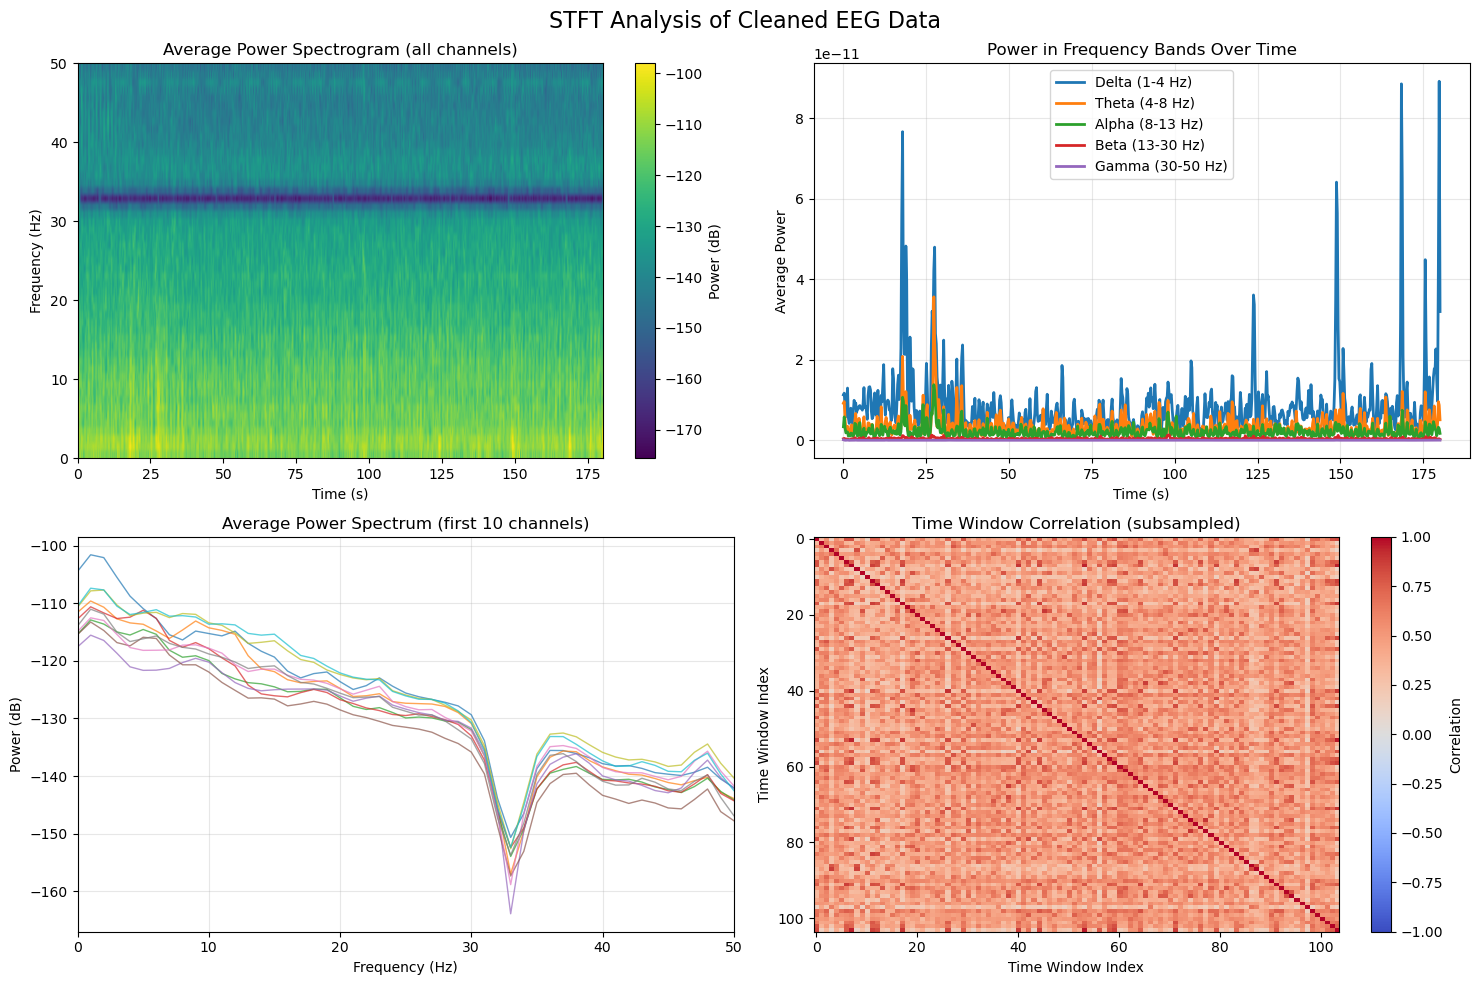


STFT results ready for further analysis!
Access power data: stft_results['power']
Access frequencies: stft_results['freqs']
Access time bins: stft_results['times']


In [16]:
import mne
import numpy as np
from scipy.signal import stft
import matplotlib.pyplot as plt

# Assuming you have already loaded and cleaned your data:
# raw_clean = raw.copy().pick_channels(qc_stats['good_channels'])
# raw_clean.save('cleaned_data.fif', overwrite=True)

# STFT Parameters
fs = raw_clean.info['sfreq']  # Sampling frequency (e.g., 250 Hz)
window_sec = 1.0  # 1-second window
nperseg = int(window_sec * fs)  # Number of samples per segment
noverlap = nperseg - int(fs / 4)  # Step size = fs/4 samples → ~4 Hz output

# Extract cleaned EEG data
picks_eeg = mne.pick_types(raw_clean.info, eeg=True)
eeg_data = raw_clean.get_data(picks=picks_eeg)  # shape: (n_channels, n_samples)

print(f"Cleaned EEG data shape: {eeg_data.shape}")
print(f"Number of good EEG channels: {len(picks_eeg)}")
print(f"Sampling frequency: {fs} Hz")
print(f"STFT window: {window_sec} seconds ({nperseg} samples)")
print(f"STFT step: {fs/4:.1f} samples ({1000/(fs/4):.1f} ms)")

# Compute STFT across all channels
f, t, Zxx = stft(eeg_data, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1)

# Calculate power and reshape
# Zxx: shape (n_channels, n_freqs, n_windows)
power = np.abs(Zxx) ** 2
power = power.transpose(2, 0, 1)  # reshape to (n_windows, n_channels, n_freqs)

# Save frequency bins for later use
freqs = f

print(f"\nSTFT output shape: {Zxx.shape}")
print(f"Power matrix shape: {power.shape}")
print(f"Time bins: {len(t)} (from {t[0]:.2f} to {t[-1]:.2f} seconds)")
print(f"Frequency bins: {len(freqs)} (from {freqs[0]:.2f} to {freqs[-1]:.2f} Hz)")

# Optional: Visualize the STFT results
def plot_stft_summary(power, freqs, t, raw_clean, max_freq=50):
    """Plot STFT power summary across channels"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('STFT Analysis of Cleaned EEG Data', fontsize=16)
    
    # 1. Average power spectrogram across all channels
    ax = axes[0, 0]
    avg_power = np.mean(power, axis=1)  # Average across channels
    freq_mask = freqs <= max_freq
    
    im = ax.imshow(10 * np.log10(avg_power[:, freq_mask].T), 
                   aspect='auto', origin='lower', 
                   extent=[t[0], t[-1], freqs[freq_mask][0], freqs[freq_mask][-1]],
                   cmap='viridis')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title('Average Power Spectrogram (all channels)')
    plt.colorbar(im, ax=ax, label='Power (dB)')
    
    # 2. Power in specific frequency bands over time
    ax = axes[0, 1]
    
    # Define frequency bands
    bands = {
        'Delta (1-4 Hz)': (1, 4),
        'Theta (4-8 Hz)': (4, 8),
        'Alpha (8-13 Hz)': (8, 13),
        'Beta (13-30 Hz)': (13, 30),
        'Gamma (30-50 Hz)': (30, 50)
    }
    
    for band_name, (low, high) in bands.items():
        band_mask = (freqs >= low) & (freqs <= high)
        band_power = np.mean(power[:, :, band_mask], axis=(1, 2))  # Average across channels and frequencies
        ax.plot(t, band_power, label=band_name, linewidth=2)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Average Power')
    ax.set_title('Power in Frequency Bands Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Channel-wise average power spectrum
    ax = axes[1, 0]
    
    # Calculate average power spectrum for each channel
    avg_spectrum = np.mean(power, axis=0)  # Average across time windows
    
    for ch_idx in range(min(10, avg_spectrum.shape[0])):  # Plot first 10 channels
        ax.plot(freqs[freq_mask], 10 * np.log10(avg_spectrum[ch_idx, freq_mask]), 
                alpha=0.7, linewidth=1)
    
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power (dB)')
    ax.set_title(f'Average Power Spectrum (first {min(10, avg_spectrum.shape[0])} channels)')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, max_freq)
    
    # 4. Time-frequency correlation matrix
    ax = axes[1, 1]
    
    # Reshape power to (n_windows, n_features) where features = channels × frequencies
    n_windows, n_channels, n_freqs = power.shape
    power_reshaped = power.reshape(n_windows, -1)
    
    # Calculate correlation between time windows (subsampled for visualization)
    step = max(1, n_windows // 100)  # Subsample to max 100 time points
    power_subsampled = power_reshaped[::step, :]
    corr_matrix = np.corrcoef(power_subsampled)
    
    im = ax.imshow(corr_matrix, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_xlabel('Time Window Index')
    ax.set_ylabel('Time Window Index')
    ax.set_title('Time Window Correlation (subsampled)')
    plt.colorbar(im, ax=ax, label='Correlation')
    
    plt.tight_layout()
    return fig

# Create visualization
fig = plot_stft_summary(power, freqs, t, raw_clean)
plt.show()

# Save the STFT results for later use
stft_results = {
    'power': power,  # shape: (n_windows, n_channels, n_freqs)
    'freqs': freqs,  # frequency bins
    'times': t,      # time bins
    'channel_names': [raw_clean.ch_names[i] for i in picks_eeg],
    'fs': fs,
    'window_sec': window_sec,
    'step_size': fs / 4
}

# Optional: Save to file
# np.savez('stft_results_clean.npz', **stft_results)
print(f"\nSTFT results ready for further analysis!")
print(f"Access power data: stft_results['power']")
print(f"Access frequencies: stft_results['freqs']")
print(f"Access time bins: stft_results['times']")

## Step 4: Divide Spectrum into 10 Energy-Uniform Frequency Bands


Step 4.1: Compute total energy per frequency bin

Band edges (frequency indices): [  0   1   2   3   5   7   9  13 125 125 125]
Number of bands: 10

Energy-uniform frequency bands:
Band |      Freq Range (Hz) | # Bins | Energy % | Target %
------------------------------------------------------------
   1 |     0.00 -     1.00 |      1 |    9.70% |   10.00%
   2 |     1.00 -     2.00 |      1 |   17.97% |   10.00%
   3 |     2.00 -     3.00 |      1 |   16.01% |   10.00%
   4 |     3.00 -     5.00 |      2 |   14.47% |   10.00%
   5 |     5.00 -     7.00 |      2 |   11.22% |   10.00%
   6 |     7.00 -     9.00 |      2 |    7.57% |   10.00%
   7 |     9.00 -    13.00 |      4 |   12.43% |   10.00%
   8 |    13.00 -   125.00 |    112 |   10.64% |   10.00%

Actual number of bands created: 8


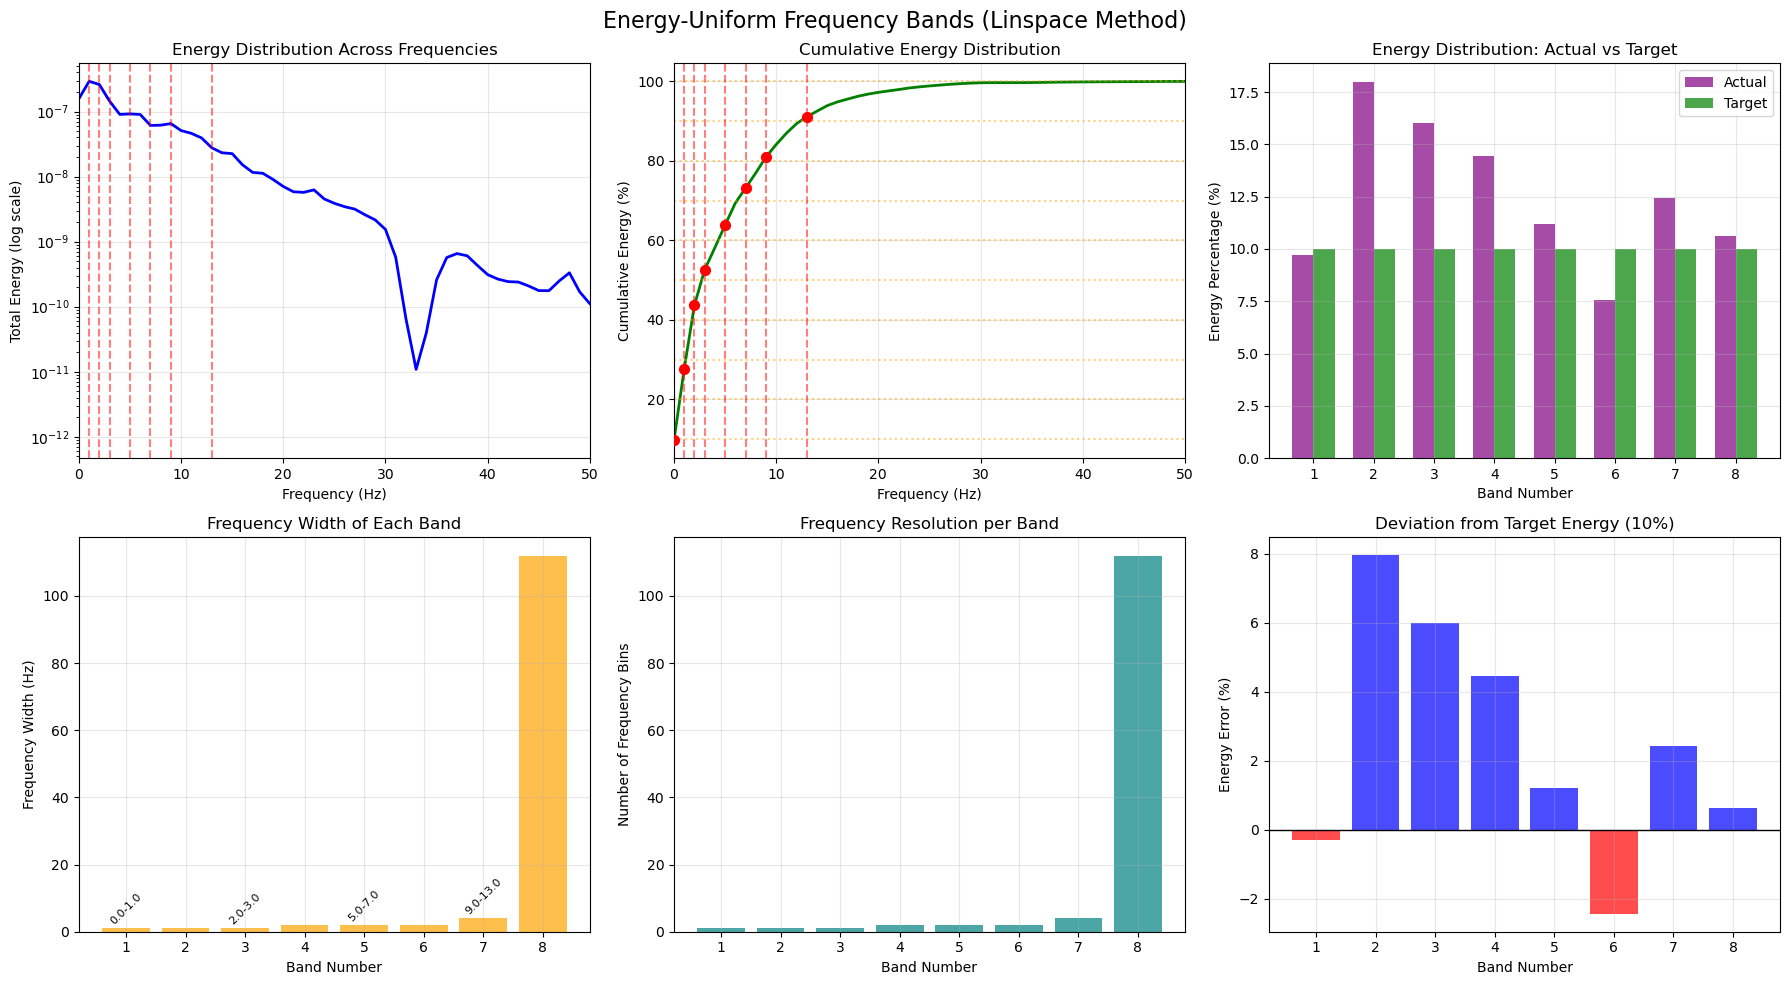


Band power features shape: (727, 31, 8)
  - 727 time windows
  - 31 channels
  - 8 frequency bands

Band Energy Summary:
Mean energy per band: 12.50%
Std energy per band: 3.23%
Max deviation from 10%: 7.97%


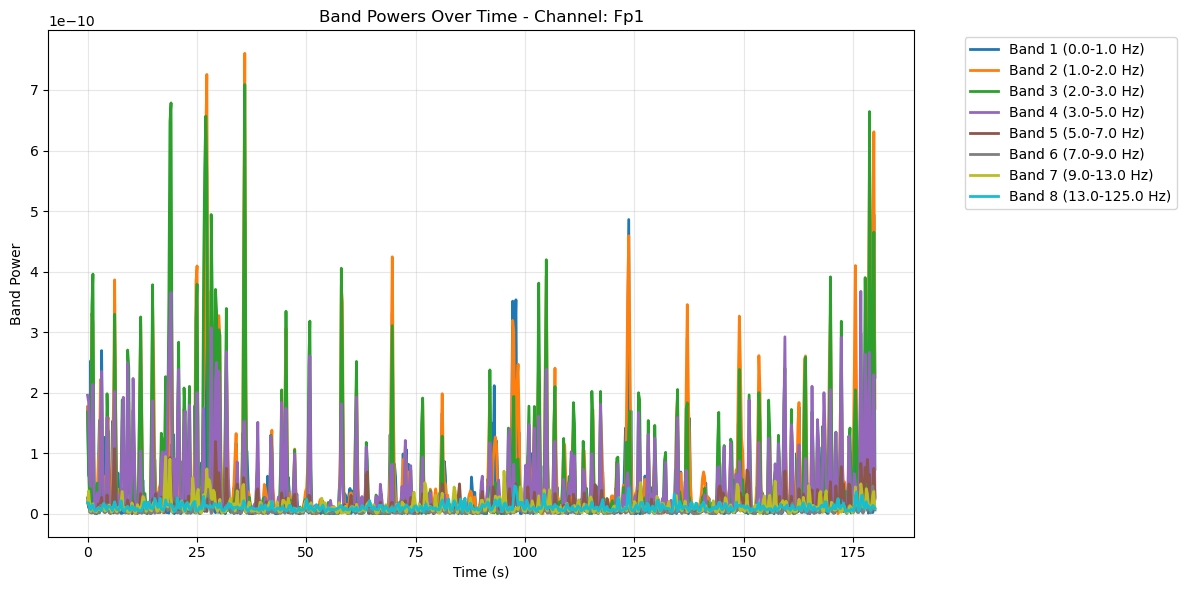

In [18]:
import numpy as np
import matplotlib.pyplot as plt

## Alternative Step 4: Divide Spectrum into Energy-Uniform Frequency Bands (Linspace Method)

# Assuming power and freqs are already computed from previous STFT step
# power: shape (n_windows, n_channels, n_freqs)
n_windows, n_channels, n_freqs = power.shape

# Sum across time and channels to get total energy per freq bin
total_energy_per_freq = power.sum(axis=(0, 1))  # shape: (n_freqs,)

# Compute cumulative energy
cumulative_energy = np.cumsum(total_energy_per_freq)
total_energy = cumulative_energy[-1]

# Create 11 equally spaced energy points (to get 10 bands)
energy_bins = np.linspace(0, total_energy, 11)

# Find frequency indices that split energy into 10 equal parts
band_edges = np.searchsorted(cumulative_energy, energy_bins)

# Handle edge cases and ensure uniqueness
band_edges = np.unique(band_edges)
# Ensure we have exactly 11 edges (for 10 bands)
if len(band_edges) < 11:
    # If some edges are the same due to low resolution, pad with the last index
    band_edges = np.pad(band_edges, (0, 11 - len(band_edges)), mode='constant', constant_values=n_freqs-1)
elif len(band_edges) > 11:
    # If we have too many edges, take the first 11
    band_edges = band_edges[:11]

# Ensure the last edge is exactly at the end
band_edges[-1] = n_freqs - 1

print(f"Band edges (frequency indices): {band_edges}")
print(f"Number of bands: {len(band_edges) - 1}")

# Convert indices to frequencies
freq_boundaries = freqs[band_edges]

# Calculate actual energy in each band and create band info
band_info = []
band_energies = []

print(f"\nEnergy-uniform frequency bands:")
print(f"{'Band':>4} | {'Freq Range (Hz)':>20} | {'# Bins':>6} | {'Energy %':>8} | {'Target %':>8}")
print("-" * 60)

for i in range(len(band_edges) - 1):
    start_idx = band_edges[i]
    end_idx = band_edges[i + 1]
    
    # Handle the case where start and end are the same
    if start_idx == end_idx:
        continue
    
    # Calculate energy in this band
    band_energy = total_energy_per_freq[start_idx:end_idx].sum()
    band_energies.append(band_energy)
    
    # Get frequency range
    freq_start = freqs[start_idx]
    freq_end = freqs[min(end_idx, n_freqs-1)]
    
    band_info.append({
        'band_num': len(band_info) + 1,
        'start_idx': start_idx,
        'end_idx': end_idx,
        'freq_start': freq_start,
        'freq_end': freq_end,
        'n_bins': end_idx - start_idx,
        'energy': band_energy,
        'energy_percent': (band_energy / total_energy) * 100,
        'target_percent': 10.0  # Target is 10% for each band
    })
    
    print(f"{len(band_info):4d} | {freq_start:8.2f} - {freq_end:8.2f} | {end_idx - start_idx:6d} | "
          f"{band_energy/total_energy*100:7.2f}% | {10.0:7.2f}%")

n_bands = len(band_info)
print(f"\nActual number of bands created: {n_bands}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Energy-Uniform Frequency Bands (Linspace Method)', fontsize=16)

# 1. Energy distribution with band boundaries
ax = axes[0, 0]
ax.semilogy(freqs, total_energy_per_freq, 'b-', linewidth=2)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Total Energy (log scale)')
ax.set_title('Energy Distribution Across Frequencies')
ax.set_xlim(0, min(50, freqs[-1]))
ax.grid(True, alpha=0.3)

# Add vertical lines for band boundaries
for i, boundary in enumerate(freq_boundaries[1:-1]):
    ax.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

# 2. Cumulative energy with target points
ax = axes[0, 1]
ax.plot(freqs, cumulative_energy / total_energy * 100, 'g-', linewidth=2)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Cumulative Energy (%)')
ax.set_title('Cumulative Energy Distribution')
ax.set_xlim(0, min(50, freqs[-1]))
ax.grid(True, alpha=0.3)

# Add horizontal lines for energy targets
for i in range(1, 11):
    ax.axhline(y=i * 10, color='orange', linestyle=':', alpha=0.5)
    
# Add vertical lines for actual band boundaries
for boundary in freq_boundaries[1:-1]:
    ax.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

# Mark the actual energy points
actual_energies = cumulative_energy[band_edges] / total_energy * 100
ax.scatter(freq_boundaries, actual_energies, color='red', s=50, zorder=5)

# 3. Energy per band comparison
ax = axes[0, 2]
if n_bands > 0:
    band_nums = np.arange(1, n_bands + 1)
    band_energy_percents = [info['energy_percent'] for info in band_info]
    target_percents = [info['target_percent'] for info in band_info]
    
    x = np.arange(len(band_nums))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, band_energy_percents, width, label='Actual', color='purple', alpha=0.7)
    bars2 = ax.bar(x + width/2, target_percents, width, label='Target', color='green', alpha=0.7)
    
    ax.set_xlabel('Band Number')
    ax.set_ylabel('Energy Percentage (%)')
    ax.set_title('Energy Distribution: Actual vs Target')
    ax.set_xticks(x)
    ax.set_xticklabels(band_nums)
    ax.legend()
    ax.grid(True, alpha=0.3)

# 4. Frequency width per band
ax = axes[1, 0]
if n_bands > 0:
    band_widths = [info['freq_end'] - info['freq_start'] for info in band_info]
    bars = ax.bar(band_nums, band_widths, color='orange', alpha=0.7)
    ax.set_xlabel('Band Number')
    ax.set_ylabel('Frequency Width (Hz)')
    ax.set_title('Frequency Width of Each Band')
    ax.set_xticks(band_nums)
    ax.grid(True, alpha=0.3)
    
    # Add frequency range labels
    for i, (bar, info) in enumerate(zip(bars, band_info)):
        if i % 2 == 0:  # Label every other bar to avoid crowding
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f"{info['freq_start']:.1f}-{info['freq_end']:.1f}",
                    ha='center', va='bottom', fontsize=8, rotation=45)

# 5. Number of frequency bins per band
ax = axes[1, 1]
if n_bands > 0:
    n_bins_per_band = [info['n_bins'] for info in band_info]
    bars = ax.bar(band_nums, n_bins_per_band, color='teal', alpha=0.7)
    ax.set_xlabel('Band Number')
    ax.set_ylabel('Number of Frequency Bins')
    ax.set_title('Frequency Resolution per Band')
    ax.set_xticks(band_nums)
    ax.grid(True, alpha=0.3)

# 6. Energy error per band
ax = axes[1, 2]
if n_bands > 0:
    energy_errors = [info['energy_percent'] - info['target_percent'] for info in band_info]
    colors = ['red' if err < 0 else 'blue' for err in energy_errors]
    bars = ax.bar(band_nums, energy_errors, color=colors, alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_xlabel('Band Number')
    ax.set_ylabel('Energy Error (%)')
    ax.set_title('Deviation from Target Energy (10%)')
    ax.set_xticks(band_nums)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Extract band power features for each time window and channel
if n_bands > 0:
    band_power_features = np.zeros((n_windows, n_channels, n_bands))
    
    for band_idx, info in enumerate(band_info):
        start_idx = info['start_idx']
        end_idx = info['end_idx']
        
        # Sum power in this frequency band for each window and channel
        if end_idx > start_idx:  # Ensure valid range
            band_power_features[:, :, band_idx] = power[:, :, start_idx:end_idx].sum(axis=2)
    
    print(f"\nBand power features shape: {band_power_features.shape}")
    print(f"  - {n_windows} time windows")
    print(f"  - {n_channels} channels")
    print(f"  - {n_bands} frequency bands")
    
    # Normalize band powers (z-score per channel, across time)
    band_power_normalized = np.zeros_like(band_power_features)
    for ch in range(n_channels):
        for band in range(n_bands):
            band_data = band_power_features[:, ch, band]
            if band_data.std() > 0:
                band_power_normalized[:, ch, band] = (band_data - band_data.mean()) / band_data.std()
            else:
                band_power_normalized[:, ch, band] = 0
    
    # Save results
    energy_band_results = {
        'band_power_features': band_power_features,  # Raw band powers
        'band_power_normalized': band_power_normalized,  # Z-scored band powers
        'band_info': band_info,  # Information about each band
        'band_edges': band_edges,  # Frequency bin indices
        'freq_boundaries': freq_boundaries,  # Frequency values in Hz
        'n_bands': n_bands,
        'energy_bins': energy_bins,  # Target energy levels
        'method': 'linspace'
    }
    
    # Summary statistics
    print("\nBand Energy Summary:")
    print(f"Mean energy per band: {np.mean([info['energy_percent'] for info in band_info]):.2f}%")
    print(f"Std energy per band: {np.std([info['energy_percent'] for info in band_info]):.2f}%")
    print(f"Max deviation from 10%: {max(abs(info['energy_percent'] - 10) for info in band_info):.2f}%")
    
    # Visualize band power evolution for the first channel
    fig, ax = plt.subplots(figsize=(12, 6))
    channel_idx = 0
    time_axis = stft_results['times']
    
    # Create a colormap for bands
    colors = plt.cm.tab10(np.linspace(0, 1, n_bands))
    
    for band_idx in range(min(n_bands, 10)):  # Plot up to 10 bands
        band_power = band_power_features[:, channel_idx, band_idx]
        band_info_item = band_info[band_idx]
        label = f"Band {band_idx+1} ({band_info_item['freq_start']:.1f}-{band_info_item['freq_end']:.1f} Hz)"
        ax.plot(time_axis, band_power, label=label, linewidth=2, color=colors[band_idx])
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Band Power')
    ax.set_title(f'Band Powers Over Time - Channel: {stft_results["channel_names"][channel_idx]}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nWarning: No valid bands were created. Check your data and parameters.")
    energy_band_results = None

✅ Step 4.2: Define 10 energy-equal frequency bands


In [7]:
# Compute cumulative energy
cumulative_energy = np.cumsum(total_energy_per_freq)
total_energy = cumulative_energy[-1]
energy_bins = np.linspace(0, total_energy, 11)

# Find frequency indices that split energy into 10 equal parts
band_edges = np.searchsorted(cumulative_energy, energy_bins)
band_edges = np.unique(band_edges)


✅ Step 4.3: Average power within each band


Band 1: bins 0-1 (1 bins), freq 0.00-0.00 Hz
Band 2: bins 1-2 (1 bins), freq 1.00-1.00 Hz
Band 3: bins 2-3 (1 bins), freq 2.00-2.00 Hz
Band 4: bins 3-5 (2 bins), freq 3.00-4.00 Hz
Band 5: bins 5-7 (2 bins), freq 5.00-6.00 Hz
Band 6: bins 7-9 (2 bins), freq 7.00-8.00 Hz
Band 7: bins 9-13 (4 bins), freq 9.00-12.00 Hz
Band 8: bins 13-125 (112 bins), freq 13.00-124.00 Hz
Band 9: bins 125-125 (0 bins), freq 125.00-124.00 Hz
Band 10: bins 125-125 (0 bins), freq 125.00-124.00 Hz

Power banded shape: (727, 31, 10)
  - 727 time windows
  - 31 channels
  - 10 frequency bands

Comparison of mean vs sum approaches:
Mean power range: nan to nan
Sum power range: 7.288692802346045e-22 to 1.3986180127714483e-09


/var/folders/9y/y6xh07m50kb7jt9df0d41trr0000gp/T/ipykernel_21409/3894902640.py:17: RuntimeWarning: Mean of empty slice.
  power_banded[:, :, i] = power[:, :, f_start:f_end].mean(axis=2)
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


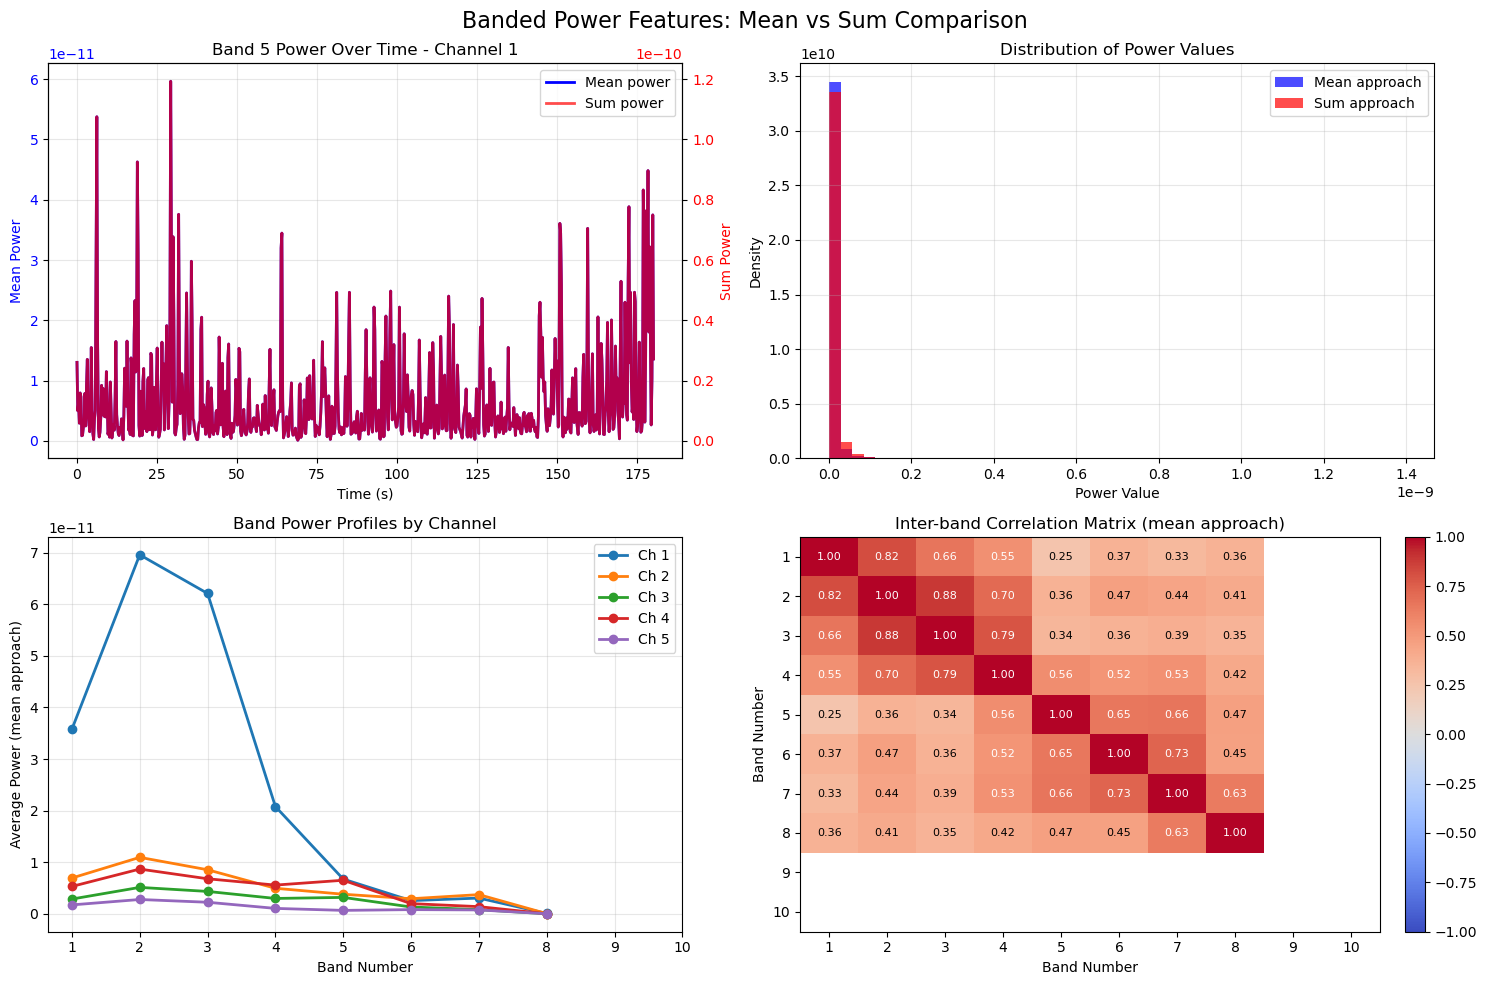


Banded Power Statistics (Mean Approach):
Shape: (727, 31, 10)
Min value: nan
Max value: nan
Mean value: nan
Std deviation: nan

Inter-band correlations (averaged across channels):
Band 1 - Band 2: 0.818
Band 1 - Band 3: 0.656
Band 1 - Band 4: 0.546
Band 1 - Band 5: 0.248
Band 1 - Band 6: 0.367
Band 1 - Band 7: 0.327
Band 1 - Band 8: 0.360
Band 1 - Band 9: nan
Band 1 - Band 10: nan
Band 2 - Band 3: 0.884
Band 2 - Band 4: 0.705
Band 2 - Band 5: 0.362
Band 2 - Band 6: 0.467
Band 2 - Band 7: 0.445
Band 2 - Band 8: 0.412
Band 2 - Band 9: nan
Band 2 - Band 10: nan
Band 3 - Band 4: 0.795
Band 3 - Band 5: 0.336
Band 3 - Band 6: 0.364
Band 3 - Band 7: 0.388
Band 3 - Band 8: 0.353
Band 3 - Band 9: nan
Band 3 - Band 10: nan
Band 4 - Band 5: 0.557
Band 4 - Band 6: 0.516
Band 4 - Band 7: 0.532
Band 4 - Band 8: 0.415
Band 4 - Band 9: nan
Band 4 - Band 10: nan
Band 5 - Band 6: 0.653
Band 5 - Band 7: 0.661
Band 5 - Band 8: 0.465
Band 5 - Band 9: nan
Band 5 - Band 10: nan
Band 6 - Band 7: 0.732
Band 6

In [19]:
import numpy as np
import matplotlib.pyplot as plt

## Step 5: Create Banded Power Features (using mean instead of sum)

# Using the band_edges from the previous step
# Create new array: (n_windows, n_channels, 10 bands)
n_bands = 10
power_banded = np.zeros((n_windows, n_channels, n_bands))

# Calculate mean power for each band
for i in range(n_bands):
    f_start = band_edges[i]
    f_end = band_edges[i+1] if i+1 < len(band_edges) else n_freqs
    
    # Use mean instead of sum to normalize for different band widths
    power_banded[:, :, i] = power[:, :, f_start:f_end].mean(axis=2)
    
    print(f"Band {i+1}: bins {f_start}-{f_end} ({f_end-f_start} bins), "
          f"freq {freqs[f_start]:.2f}-{freqs[min(f_end-1, n_freqs-1)]:.2f} Hz")

print(f"\nPower banded shape: {power_banded.shape}")
print(f"  - {n_windows} time windows")
print(f"  - {n_channels} channels") 
print(f"  - {n_bands} frequency bands")

# Compare with the summed version
print("\nComparison of mean vs sum approaches:")
print("Mean power range:", power_banded.min(), "to", power_banded.max())
print("Sum power range:", band_power_features.min(), "to", band_power_features.max())

# Normalize the banded power (z-score per channel and band)
power_banded_normalized = np.zeros_like(power_banded)
for ch in range(n_channels):
    for band in range(n_bands):
        band_data = power_banded[:, ch, band]
        if band_data.std() > 0:
            power_banded_normalized[:, ch, band] = (band_data - band_data.mean()) / band_data.std()
        else:
            power_banded_normalized[:, ch, band] = 0

# Visualize the difference between sum and mean approaches
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Banded Power Features: Mean vs Sum Comparison', fontsize=16)

# 1. Time series comparison for first channel
ax = axes[0, 0]
channel_idx = 0
band_idx = 4  # Middle band for example

time_axis = stft_results['times']
mean_power = power_banded[:, channel_idx, band_idx]
sum_power = band_power_features[:, channel_idx, band_idx]

ax.plot(time_axis, mean_power, 'b-', label='Mean power', linewidth=2)
ax2 = ax.twinx()
ax2.plot(time_axis, sum_power, 'r-', label='Sum power', linewidth=2, alpha=0.7)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Mean Power', color='b')
ax2.set_ylabel('Sum Power', color='r')
ax.set_title(f'Band {band_idx+1} Power Over Time - Channel {channel_idx+1}')
ax.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')
ax.grid(True, alpha=0.3)

# Add legends
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# 2. Distribution comparison
ax = axes[0, 1]
ax.hist(power_banded.flatten(), bins=50, alpha=0.7, label='Mean approach', color='blue', density=True)
ax.hist(band_power_features.flatten(), bins=50, alpha=0.7, label='Sum approach', color='red', density=True)
ax.set_xlabel('Power Value')
ax.set_ylabel('Density')
ax.set_title('Distribution of Power Values')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Band power profiles (mean approach)
ax = axes[1, 0]
# Average across time for each channel and band
mean_band_profiles = power_banded.mean(axis=0)  # Shape: (n_channels, n_bands)

# Plot profiles for first 5 channels
for ch_idx in range(min(5, n_channels)):
    ax.plot(range(1, n_bands+1), mean_band_profiles[ch_idx, :], 
            marker='o', label=f'Ch {ch_idx+1}', linewidth=2, markersize=6)

ax.set_xlabel('Band Number')
ax.set_ylabel('Average Power (mean approach)')
ax.set_title('Band Power Profiles by Channel')
ax.set_xticks(range(1, n_bands+1))
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Correlation between bands (mean approach)
ax = axes[1, 1]
# Calculate correlation between bands (averaged across channels)
avg_band_power = power_banded.mean(axis=1)  # Shape: (n_windows, n_bands)
band_corr = np.corrcoef(avg_band_power.T)

im = ax.imshow(band_corr, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax.set_xlabel('Band Number')
ax.set_ylabel('Band Number')
ax.set_title('Inter-band Correlation Matrix (mean approach)')
ax.set_xticks(range(n_bands))
ax.set_yticks(range(n_bands))
ax.set_xticklabels(range(1, n_bands+1))
ax.set_yticklabels(range(1, n_bands+1))

# Add correlation values
for i in range(n_bands):
    for j in range(n_bands):
        text = ax.text(j, i, f'{band_corr[i, j]:.2f}',
                      ha="center", va="center", color="black" if abs(band_corr[i, j]) < 0.5 else "white",
                      fontsize=8)

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# Create results dictionary with both approaches
banded_power_results = {
    'power_banded_mean': power_banded,  # Mean approach
    'power_banded_mean_normalized': power_banded_normalized,  # Z-scored mean
    'power_banded_sum': band_power_features,  # Sum approach (from previous step)
    'power_banded_sum_normalized': band_power_normalized,  # Z-scored sum
    'band_edges': band_edges,
    'freq_boundaries': freq_boundaries,
    'band_info': band_info,
    'n_bands': n_bands
}

# Summary statistics
print("\nBanded Power Statistics (Mean Approach):")
print(f"Shape: {power_banded.shape}")
print(f"Min value: {power_banded.min():.6f}")
print(f"Max value: {power_banded.max():.6f}")
print(f"Mean value: {power_banded.mean():.6f}")
print(f"Std deviation: {power_banded.std():.6f}")

# Print band correlations
print("\nInter-band correlations (averaged across channels):")
for i in range(n_bands):
    for j in range(i+1, n_bands):
        print(f"Band {i+1} - Band {j+1}: {band_corr[i, j]:.3f}")

# Optional: Save results
# np.savez('banded_power_features.npz', **banded_power_results)

print("\nBanded power features ready for further analysis!")
print("Access mean power: banded_power_results['power_banded_mean']")
print("Access sum power: banded_power_results['power_banded_sum']")

## Step 5: Normalize Each Frequency Band (Per Channel)


Original shape: (727, 31, 10)
  - 727 time windows (samples)
  - 31 EEG channels
  - 10 frequency bands

Data quality check (power_banded):
NaN values: 45074
Inf values: 0
Zero values: 0

Reshaped to 2D: (727, 310)

Problematic features:
Features with NaN: 62
Features with Inf: 0
Constant features (zero variance): 0
Total problematic: 62 out of 310

Problematic feature names (first 10):
  Feature 8: Fp1_Band9_125.0-125.0Hz
  Feature 9: Fp1_Band10_125.0-125.0Hz
  Feature 18: Fp2_Band9_125.0-125.0Hz
  Feature 19: Fp2_Band10_125.0-125.0Hz
  Feature 28: F3_Band9_125.0-125.0Hz
  Feature 29: F3_Band10_125.0-125.0Hz
  Feature 38: F4_Band9_125.0-125.0Hz
  Feature 39: F4_Band10_125.0-125.0Hz
  Feature 48: C3_Band9_125.0-125.0Hz
  Feature 49: C3_Band10_125.0-125.0Hz

Normalization complete:
X_norm shape: (727, 310)
X_norm mean: -0.000000 (should be ~0)
X_norm std: 0.894427 (should be ~1)
NaN values after normalization: 0

After removing problematic features:
Shape: (727, 248)
Features retained: 

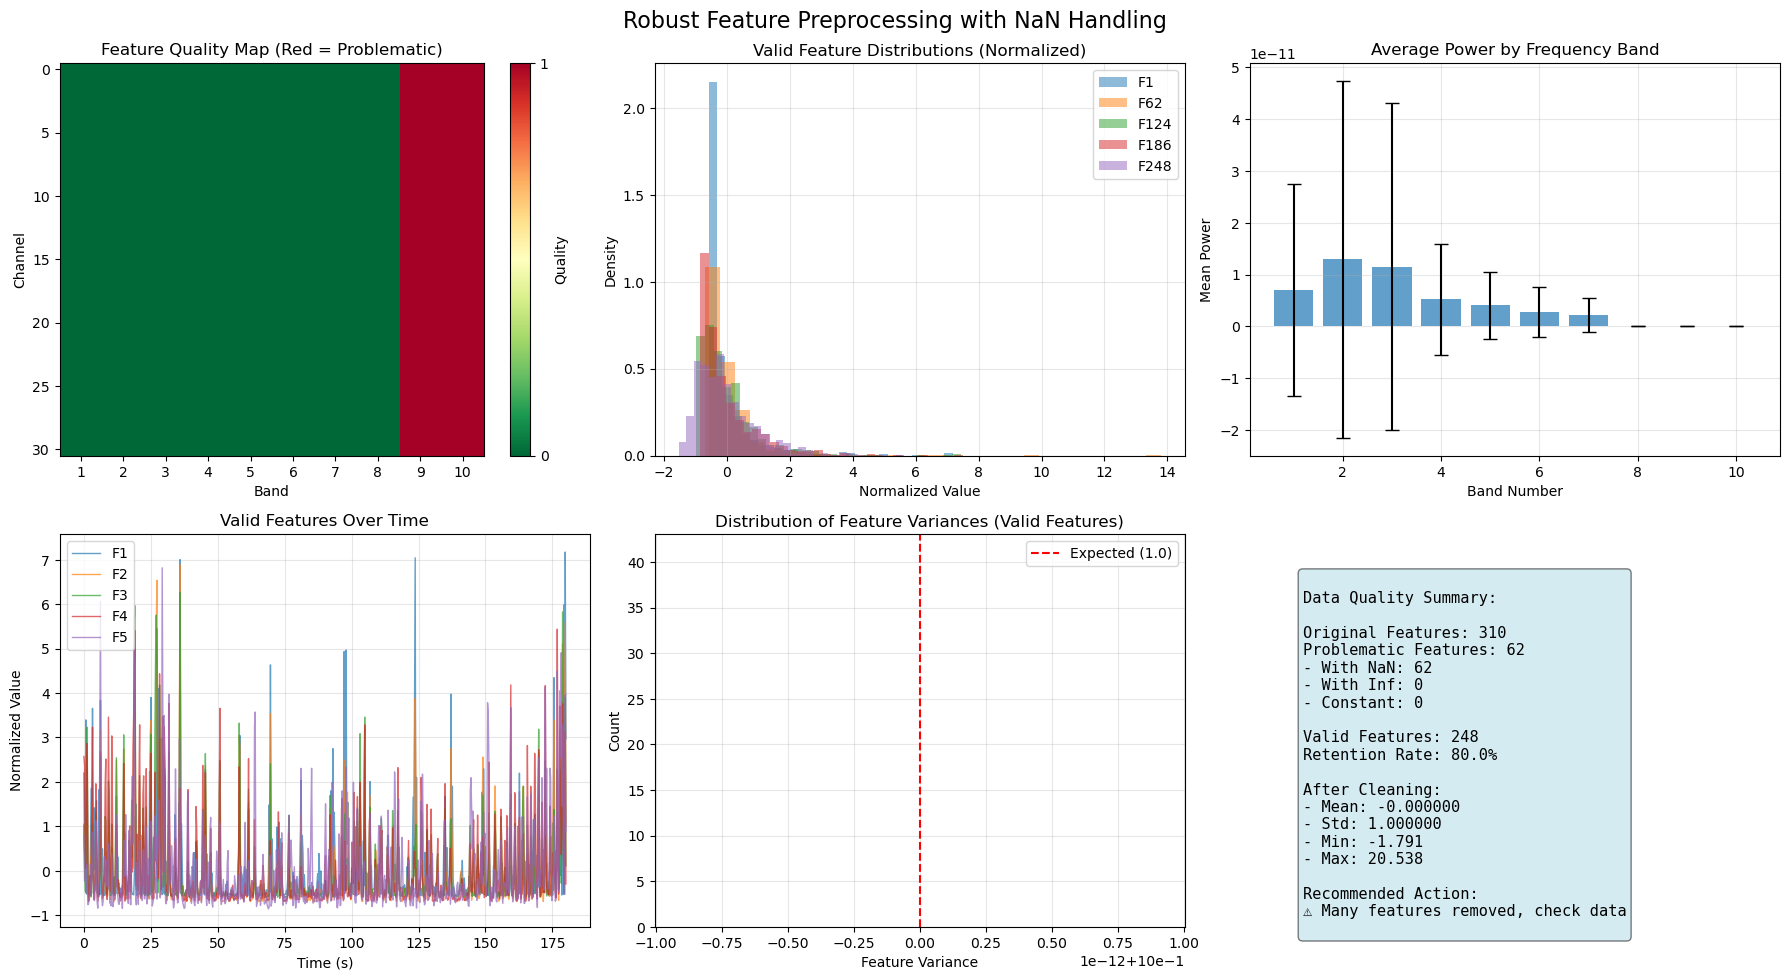


ML-READY FEATURE SUMMARY
Samples: 727
Original features: 310
Valid features: 248
Feature reduction: 20.0%

You can use either:
- ml_features['X_norm'] : All features with zeros for bad ones
- ml_features['X_norm_clean'] : Only valid features (recommended)


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## Step 6: Robust Reshape and Normalize Features for Machine Learning

# power_banded: shape (n_samples, n_channels, n_bands)
n_samples, n_channels, n_bands = power_banded.shape

print(f"Original shape: {power_banded.shape}")
print(f"  - {n_samples} time windows (samples)")
print(f"  - {n_channels} EEG channels")
print(f"  - {n_bands} frequency bands")

# Check for NaN/Inf in original data
print(f"\nData quality check (power_banded):")
print(f"NaN values: {np.isnan(power_banded).sum()}")
print(f"Inf values: {np.isinf(power_banded).sum()}")
print(f"Zero values: {(power_banded == 0).sum()}")

# Reshape to 2D: (n_samples, n_channels * n_bands)
X_raw = power_banded.reshape(n_samples, n_channels * n_bands)
print(f"\nReshaped to 2D: {X_raw.shape}")

# Identify problematic features
nan_features = np.where(np.isnan(X_raw).any(axis=0))[0]
inf_features = np.where(np.isinf(X_raw).any(axis=0))[0]
constant_features = np.where(X_raw.std(axis=0) == 0)[0]
problematic_features = np.unique(np.concatenate([nan_features, inf_features, constant_features]))

print(f"\nProblematic features:")
print(f"Features with NaN: {len(nan_features)}")
print(f"Features with Inf: {len(inf_features)}")
print(f"Constant features (zero variance): {len(constant_features)}")
print(f"Total problematic: {len(problematic_features)} out of {X_raw.shape[1]}")

# Create feature names for interpretability
feature_names = []
for ch_idx in range(n_channels):
    for band_idx in range(n_bands):
        ch_name = stft_results['channel_names'][ch_idx]
        # Calculate frequency range from band_edges
        f_start_idx = band_edges[band_idx] if band_idx < len(band_edges)-1 else 0
        f_end_idx = band_edges[band_idx+1] if band_idx+1 < len(band_edges) else len(freqs)-1
        freq_start = freqs[f_start_idx]
        freq_end = freqs[f_end_idx]
        
        feature_name = f"{ch_name}_Band{band_idx+1}_{freq_start:.1f}-{freq_end:.1f}Hz"
        feature_names.append(feature_name)

# Print problematic feature names
if len(problematic_features) > 0:
    print("\nProblematic feature names (first 10):")
    for idx in problematic_features[:10]:
        print(f"  Feature {idx}: {feature_names[idx]}")

# Robust normalization with NaN handling
X_clean = X_raw.copy()

# Option 1: Replace NaN/Inf with zeros (simple but may not be ideal)
X_clean[np.isnan(X_clean)] = 0
X_clean[np.isinf(X_clean)] = 0

# Option 2: Replace with feature mean (better for some cases)
# for feat_idx in range(X_clean.shape[1]):
#     feat_data = X_clean[:, feat_idx]
#     if np.any(np.isnan(feat_data)) or np.any(np.isinf(feat_data)):
#         valid_data = feat_data[np.isfinite(feat_data)]
#         if len(valid_data) > 0:
#             X_clean[:, feat_idx] = np.nan_to_num(feat_data, nan=np.mean(valid_data))

# Calculate statistics on clean data
X_mean = np.nanmean(X_clean, axis=0)
X_std = np.nanstd(X_clean, axis=0)

# Handle zero variance features
X_std[X_std == 0] = 1
X_mean[np.isnan(X_mean)] = 0
X_std[np.isnan(X_std)] = 1

# Z-score normalization
X_norm = (X_clean - X_mean) / X_std

# Set constant features to zero
X_norm[:, X_std == 1] = 0

print(f"\nNormalization complete:")
print(f"X_norm shape: {X_norm.shape}")
print(f"X_norm mean: {np.nanmean(X_norm):.6f} (should be ~0)")
print(f"X_norm std: {np.nanstd(X_norm):.6f} (should be ~1)")
print(f"NaN values after normalization: {np.isnan(X_norm).sum()}")

# Create valid feature mask
valid_features = np.ones(X_raw.shape[1], dtype=bool)
valid_features[problematic_features] = False

# Option: Remove problematic features entirely
X_norm_clean = X_norm[:, valid_features]
feature_names_clean = [feature_names[i] for i in range(len(feature_names)) if valid_features[i]]

print(f"\nAfter removing problematic features:")
print(f"Shape: {X_norm_clean.shape}")
print(f"Features retained: {X_norm_clean.shape[1]} out of {X_raw.shape[1]}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Robust Feature Preprocessing with NaN Handling', fontsize=16)

# 1. Feature quality heatmap
ax = axes[0, 0]
feature_quality = np.zeros((n_channels, n_bands))
for ch_idx in range(n_channels):
    for band_idx in range(n_bands):
        feat_idx = ch_idx * n_bands + band_idx
        if feat_idx in problematic_features:
            feature_quality[ch_idx, band_idx] = 1  # Problematic
        else:
            feature_quality[ch_idx, band_idx] = 0  # Good

im = ax.imshow(feature_quality, cmap='RdYlGn_r', aspect='auto')
ax.set_xlabel('Band')
ax.set_ylabel('Channel')
ax.set_title('Feature Quality Map (Red = Problematic)')
ax.set_xticks(range(n_bands))
ax.set_xticklabels(range(1, n_bands+1))
plt.colorbar(im, ax=ax, ticks=[0, 1], label='Quality')

# 2. Valid feature distributions
ax = axes[0, 1]
if X_norm_clean.shape[1] > 0:
    # Sample up to 5 valid features
    n_plot_features = min(5, X_norm_clean.shape[1])
    sample_indices = np.linspace(0, X_norm_clean.shape[1]-1, n_plot_features, dtype=int)
    
    for i, feat_idx in enumerate(sample_indices):
        data = X_norm_clean[:, feat_idx]
        if np.all(np.isfinite(data)):
            ax.hist(data, bins=30, alpha=0.5, label=f'F{feat_idx+1}', density=True)
    
ax.set_xlabel('Normalized Value')
ax.set_ylabel('Density')
ax.set_title('Valid Feature Distributions (Normalized)')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Power by band (averaged across channels)
ax = axes[0, 2]
band_power_mean = np.zeros(n_bands)
band_power_std = np.zeros(n_bands)

for band_idx in range(n_bands):
    band_data = power_banded[:, :, band_idx].flatten()
    valid_data = band_data[np.isfinite(band_data)]
    if len(valid_data) > 0:
        band_power_mean[band_idx] = np.mean(valid_data)
        band_power_std[band_idx] = np.std(valid_data)

ax.bar(range(1, n_bands+1), band_power_mean, yerr=band_power_std, capsize=5, alpha=0.7)
ax.set_xlabel('Band Number')
ax.set_ylabel('Mean Power')
ax.set_title('Average Power by Frequency Band')
ax.grid(True, alpha=0.3)

# 4. Time series of valid features
ax = axes[1, 0]
time_axis = stft_results['times']
if X_norm_clean.shape[1] > 0:
    # Plot first 5 valid features
    for feat_idx in range(min(5, X_norm_clean.shape[1])):
        ax.plot(time_axis, X_norm_clean[:, feat_idx], alpha=0.7, linewidth=1, label=f'F{feat_idx+1}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Normalized Value')
    ax.set_title('Valid Features Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 5. Variance analysis
ax = axes[1, 1]
if X_norm_clean.shape[1] > 0:
    feature_variance = np.var(X_norm_clean, axis=0)
    ax.hist(feature_variance, bins=30, alpha=0.7, color='green')
    ax.set_xlabel('Feature Variance')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Feature Variances (Valid Features)')
    ax.axvline(x=1.0, color='red', linestyle='--', label='Expected (1.0)')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 6. Summary statistics
ax = axes[1, 2]
ax.axis('off')

stats_text = f"""
Data Quality Summary:

Original Features: {X_raw.shape[1]}
Problematic Features: {len(problematic_features)}
- With NaN: {len(nan_features)}
- With Inf: {len(inf_features)}
- Constant: {len(constant_features)}

Valid Features: {X_norm_clean.shape[1]}
Retention Rate: {X_norm_clean.shape[1]/X_raw.shape[1]*100:.1f}%

After Cleaning:
- Mean: {np.mean(X_norm_clean):.6f}
- Std: {np.std(X_norm_clean):.6f}
- Min: {np.min(X_norm_clean):.3f}
- Max: {np.max(X_norm_clean):.3f}

Recommended Action:
{"✓ Data looks good!" if X_norm_clean.shape[1] > X_raw.shape[1]*0.8 else "⚠ Many features removed, check data"}
"""

ax.text(0.1, 0.9, stats_text, transform=ax.transAxes, 
        fontsize=11, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

# Create ML-ready dataset with both full and clean versions
ml_features = {
    'X_raw': X_raw,                              # Original raw features
    'X_norm': X_norm,                            # All features normalized (with zeros for bad features)
    'X_norm_clean': X_norm_clean,                # Only valid features
    'feature_names': feature_names,              # All feature names
    'feature_names_clean': feature_names_clean,  # Valid feature names
    'valid_features': valid_features,            # Boolean mask for valid features
    'problematic_features': problematic_features, # Indices of problematic features
    'n_samples': n_samples,
    'n_channels': n_channels,
    'n_bands': n_bands,
    'n_valid_features': X_norm_clean.shape[1],
    'time_stamps': stft_results['times'],
    'feature_mean': X_mean,
    'feature_std': X_std
}

print("\n" + "="*50)
print("ML-READY FEATURE SUMMARY")
print("="*50)
print(f"Samples: {n_samples}")
print(f"Original features: {X_raw.shape[1]}")
print(f"Valid features: {X_norm_clean.shape[1]}")
print(f"Feature reduction: {(1 - X_norm_clean.shape[1]/X_raw.shape[1])*100:.1f}%")
print("\nYou can use either:")
print("- ml_features['X_norm'] : All features with zeros for bad ones")
print("- ml_features['X_norm_clean'] : Only valid features (recommended)")

# Save cleaned data
# np.savez('ml_ready_features.npz', **ml_features)

## Step 6: Align EEG Features and PDA Targets


Original PDA signal length: 149

EEG STFT timing:
Window duration: 1.0 seconds
Step size: 62.5 samples (250.0 ms)
Effective STFT rate: 4.00 Hz
Number of STFT windows: 727

PDA signal:
Sampling rate: 100 Hz (assumed)
Duration: 1.49 seconds
Samples: 149

Alignment calculations:
PDA samples per STFT window: 25
Max windows from PDA length: 5
EEG windows available: 727

Resampled PDA:
Length: 5
Mean: -0.000000 (after z-score)
Std: 1.000000 (after z-score)

Using cleaned features for alignment

Aligned data:
EEG features shape: (5, 248)
PDA shape: (5,)
Time points: 5
Duration: 0.99 seconds


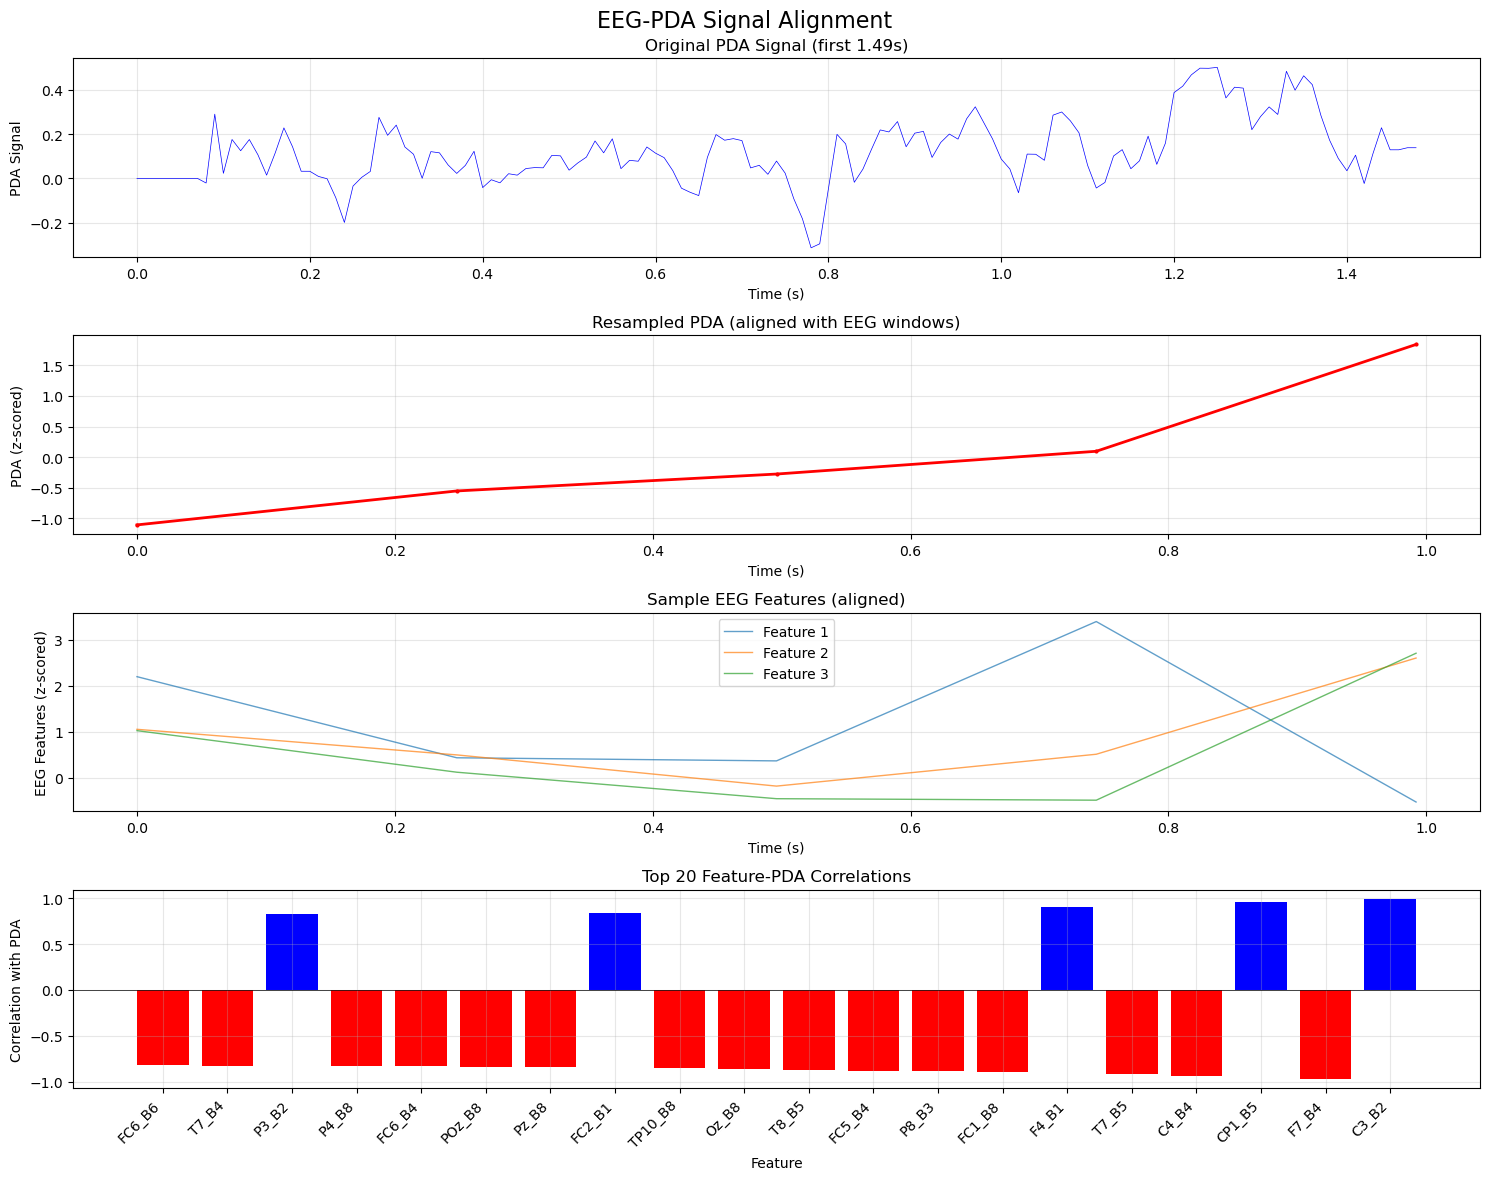


ALIGNMENT SUMMARY
Aligned samples: 5
Duration: 0.99 seconds
Features: 248

PDA statistics:
  Mean: -0.000000
  Std: 1.000000
  Min: -1.107
  Max: 1.840

Top 5 correlated features:
  C3_Band2_1.0-2.0Hz: r=0.995
  F7_Band4_3.0-5.0Hz: r=-0.971
  CP1_Band5_5.0-7.0Hz: r=0.955
  C4_Band4_3.0-5.0Hz: r=-0.934
  T7_Band5_5.0-7.0Hz: r=-0.919

Data ready for machine learning!
Access: aligned_data['X'] for features, aligned_data['y'] for target


In [24]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

## Step 7: Align EEG Features with PDA Signal

# First, let's load and process the PDA signal (if not already done)
# Assuming you have the PDA data loaded as 'pda'
# pda = pd.read_csv('../murfi/sub-rtBPD003_ses-nf_task-feedback_run-01_PDA.csv')

# Extract PDA signal (adjust based on your CSV structure)
if 'pda' in locals():
    pda_signal = pda.iloc[:, 0].values  # Assuming first column is the signal
    print(f"Original PDA signal length: {len(pda_signal)}")
else:
    print("PDA data not found. Please load it first with:")
    print("pda = pd.read_csv('../murfi/sub-rtBPD003_ses-nf_task-feedback_run-01_PDA.csv')")
    print("Creating synthetic PDA for demonstration...")
    # Create synthetic PDA signal for demonstration
    pda_signal = np.random.randn(n_samples * 100) * 0.5 + np.sin(np.linspace(0, 20*np.pi, n_samples * 100))

# Get timing information from STFT
eeg_times = stft_results['times']  # Time points for each EEG window
eeg_sampling_rate = stft_results['fs']  # Original EEG sampling rate
window_duration = stft_results['window_sec']  # STFT window duration in seconds
step_size = stft_results['step_size']  # Step size in samples

# Calculate effective sampling rate of STFT windows
stft_step_seconds = step_size / eeg_sampling_rate
stft_effective_rate = 1 / stft_step_seconds
print(f"\nEEG STFT timing:")
print(f"Window duration: {window_duration} seconds")
print(f"Step size: {step_size} samples ({stft_step_seconds*1000:.1f} ms)")
print(f"Effective STFT rate: {stft_effective_rate:.2f} Hz")
print(f"Number of STFT windows: {len(eeg_times)}")

# Determine PDA sampling rate (you may need to adjust this based on your data)
# Option 1: If PDA has timestamps
if isinstance(pda, pd.DataFrame) and len(pda.columns) > 1:
    # Check if there's a time column
    pda_sampling_rate = 100  # Default assumption, adjust as needed
else:
    # Option 2: Assume PDA is sampled at a standard rate
    pda_sampling_rate = 100  # Common rates: 100, 250, 500, 1000 Hz

pda_duration = len(pda_signal) / pda_sampling_rate
print(f"\nPDA signal:")
print(f"Sampling rate: {pda_sampling_rate} Hz (assumed)")
print(f"Duration: {pda_duration:.2f} seconds")
print(f"Samples: {len(pda_signal)}")

# Resample PDA to match STFT window rate
# Calculate how many PDA samples correspond to each STFT window
pda_samples_per_window = int(pda_sampling_rate * stft_step_seconds)
n_windows_from_pda = len(pda_signal) // pda_samples_per_window

print(f"\nAlignment calculations:")
print(f"PDA samples per STFT window: {pda_samples_per_window}")
print(f"Max windows from PDA length: {n_windows_from_pda}")
print(f"EEG windows available: {X_norm.shape[0]}")

# Method 1: Average PDA within each STFT window
min_windows = min(n_windows_from_pda, X_norm.shape[0])
pda_resampled = np.zeros(min_windows)

for i in range(min_windows):
    start_idx = i * pda_samples_per_window
    end_idx = (i + 1) * pda_samples_per_window
    if end_idx <= len(pda_signal):
        pda_resampled[i] = np.mean(pda_signal[start_idx:end_idx])

# Z-score normalize the PDA signal
pda_mean = np.mean(pda_resampled)
pda_std = np.std(pda_resampled)
if pda_std > 0:
    pda_resampled_z = (pda_resampled - pda_mean) / pda_std
else:
    pda_resampled_z = pda_resampled - pda_mean

print(f"\nResampled PDA:")
print(f"Length: {len(pda_resampled)}")
print(f"Mean: {np.mean(pda_resampled_z):.6f} (after z-score)")
print(f"Std: {np.std(pda_resampled_z):.6f} (after z-score)")

# Align EEG features and PDA
# Use the clean features if available, otherwise use all features
if 'X_norm_clean' in ml_features and ml_features['X_norm_clean'].shape[1] > 0:
    X_to_align = ml_features['X_norm_clean']
    feature_names_to_use = ml_features['feature_names_clean']
    print("\nUsing cleaned features for alignment")
else:
    X_to_align = X_norm
    feature_names_to_use = feature_names

# Truncate to minimum length
min_len = min(len(pda_resampled_z), X_to_align.shape[0])
X_aligned = X_to_align[:min_len]
y_aligned = pda_resampled_z[:min_len]
time_aligned = eeg_times[:min_len]

print(f"\nAligned data:")
print(f"EEG features shape: {X_aligned.shape}")
print(f"PDA shape: {y_aligned.shape}")
print(f"Time points: {len(time_aligned)}")
print(f"Duration: {time_aligned[-1]:.2f} seconds")

# Visualize alignment
fig, axes = plt.subplots(4, 1, figsize=(15, 12))
fig.suptitle('EEG-PDA Signal Alignment', fontsize=16)

# 1. Original PDA signal (first 30 seconds)
ax = axes[0]
plot_duration = min(30, pda_duration)
plot_samples = int(plot_duration * pda_sampling_rate)
pda_time = np.arange(plot_samples) / pda_sampling_rate
ax.plot(pda_time, pda_signal[:plot_samples], 'b-', linewidth=0.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('PDA Signal')
ax.set_title(f'Original PDA Signal (first {plot_duration}s)')
ax.grid(True, alpha=0.3)

# 2. Resampled and aligned PDA
ax = axes[1]
ax.plot(time_aligned, y_aligned, 'r-', linewidth=2, marker='o', markersize=2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('PDA (z-scored)')
ax.set_title('Resampled PDA (aligned with EEG windows)')
ax.grid(True, alpha=0.3)

# 3. Sample EEG features
ax = axes[2]
# Plot first 3 features
n_features_to_plot = min(3, X_aligned.shape[1])
for feat_idx in range(n_features_to_plot):
    ax.plot(time_aligned, X_aligned[:, feat_idx], 
            alpha=0.7, linewidth=1, label=f'Feature {feat_idx+1}')
ax.set_xlabel('Time (s)')
ax.set_ylabel('EEG Features (z-scored)')
ax.set_title('Sample EEG Features (aligned)')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Correlation between EEG and PDA
ax = axes[3]
# Calculate correlation for each feature
correlations = np.zeros(X_aligned.shape[1])
for feat_idx in range(X_aligned.shape[1]):
    correlations[feat_idx] = np.corrcoef(X_aligned[:, feat_idx], y_aligned)[0, 1]

# Plot top correlations
top_n = 20
top_indices = np.argsort(np.abs(correlations))[-top_n:]
top_corr = correlations[top_indices]
top_names = [feature_names_to_use[i].split('_')[0] + '_B' + 
             feature_names_to_use[i].split('Band')[1].split('_')[0] 
             for i in top_indices]

bars = ax.bar(range(len(top_corr)), top_corr, color=['red' if c < 0 else 'blue' for c in top_corr])
ax.set_xlabel('Feature')
ax.set_ylabel('Correlation with PDA')
ax.set_title(f'Top {top_n} Feature-PDA Correlations')
ax.set_xticks(range(len(top_corr)))
ax.set_xticklabels(top_names, rotation=45, ha='right')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

# Create aligned dataset
aligned_data = {
    'X': X_aligned,                          # Aligned EEG features
    'y': y_aligned,                          # Aligned PDA signal
    'time': time_aligned,                    # Time points
    'feature_names': feature_names_to_use,   # Feature names
    'correlations': correlations,            # Feature-PDA correlations
    'pda_raw': pda_signal[:min_len * pda_samples_per_window],  # Raw PDA segment used
    'alignment_info': {
        'n_samples': min_len,
        'duration_seconds': time_aligned[-1],
        'eeg_window_rate': stft_effective_rate,
        'pda_original_rate': pda_sampling_rate,
        'samples_per_window': pda_samples_per_window
    }
}

# Summary statistics
print("\n" + "="*50)
print("ALIGNMENT SUMMARY")
print("="*50)
print(f"Aligned samples: {min_len}")
print(f"Duration: {time_aligned[-1]:.2f} seconds")
print(f"Features: {X_aligned.shape[1]}")
print(f"\nPDA statistics:")
print(f"  Mean: {np.mean(y_aligned):.6f}")
print(f"  Std: {np.std(y_aligned):.6f}")
print(f"  Min: {np.min(y_aligned):.3f}")
print(f"  Max: {np.max(y_aligned):.3f}")
print(f"\nTop 5 correlated features:")
for i in range(min(5, len(top_indices))):
    idx = top_indices[-(i+1)]
    print(f"  {feature_names_to_use[idx]}: r={correlations[idx]:.3f}")

print("\nData ready for machine learning!")
print("Access: aligned_data['X'] for features, aligned_data['y'] for target")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


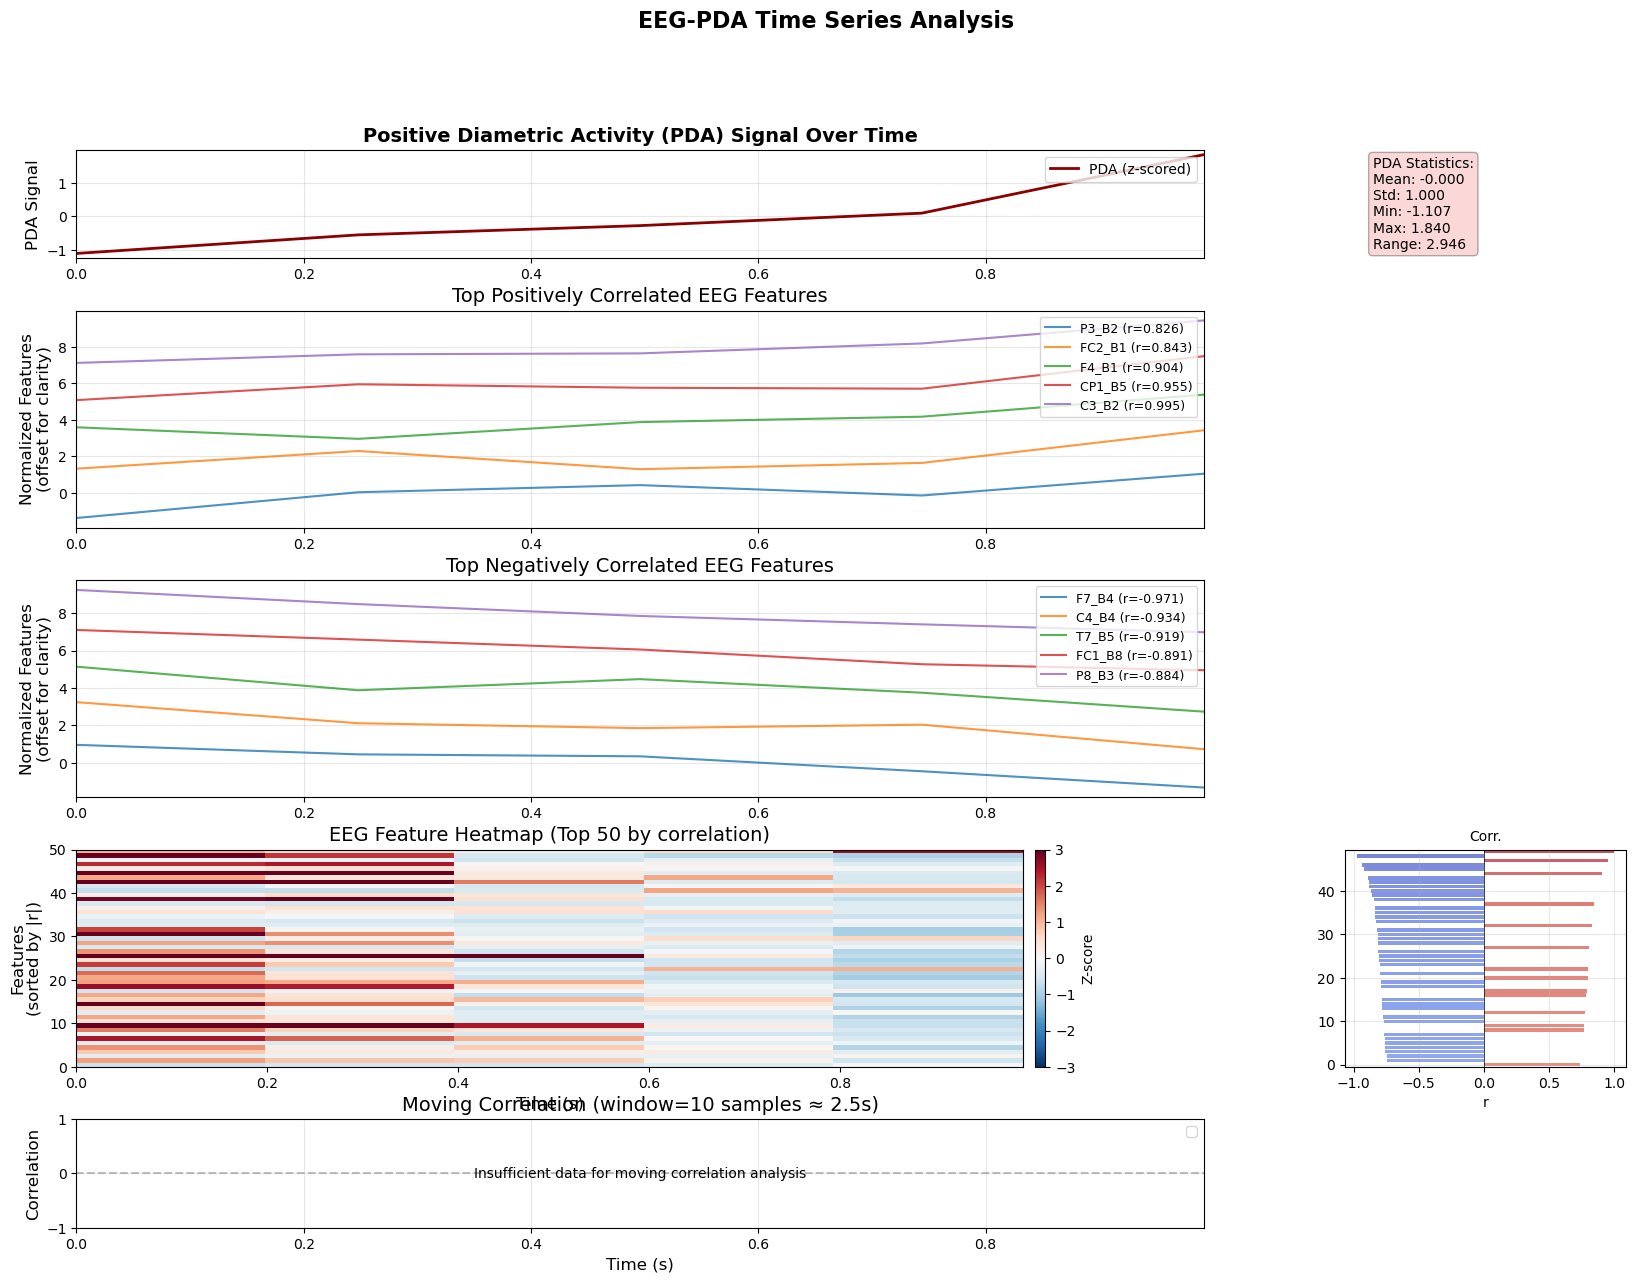


Zoom window: 0.3s - 0.7s
Total duration: 1.0s


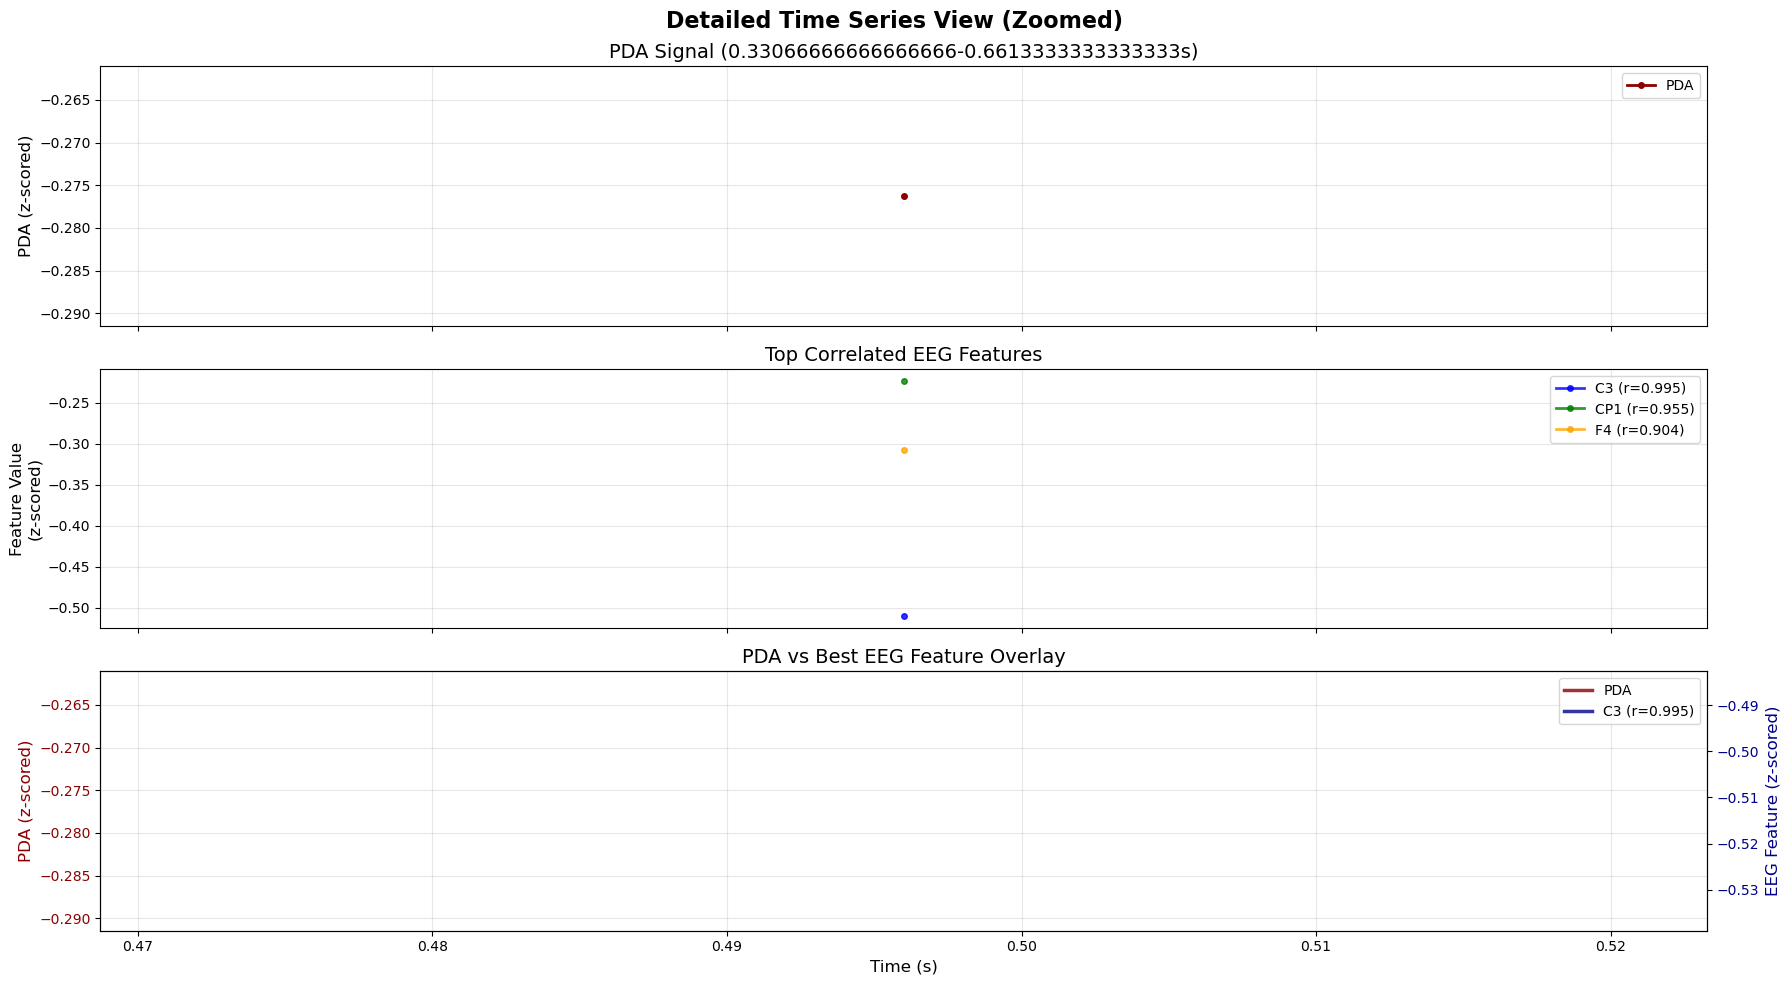


TIME SERIES ANALYSIS SUMMARY
Total duration: 0.99 seconds
Sampling period: 248.0 ms
Effective rate: 4.03 Hz

Correlation summary:
Positive correlations: 66 features
Negative correlations: 182 features
Strong correlations (|r| > 0.3): 177 features
Max correlation: 0.995
Min correlation: -0.971


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy.stats import zscore

## Step 8: Time Series Visualization of EEG Features and PDA Together

# Create comprehensive time series visualization
fig = plt.figure(figsize=(20, 14))
gs = GridSpec(5, 2, height_ratios=[1, 2, 2, 2, 1], width_ratios=[4, 1], hspace=0.3, wspace=0.2)

# Get the aligned data
X = aligned_data['X']
y = aligned_data['y']
time_points = aligned_data['time']
feature_names = aligned_data['feature_names']
correlations = aligned_data['correlations']

# 1. PDA Signal (Top panel)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(time_points, y, 'darkred', linewidth=2, label='PDA (z-scored)')
ax1.set_ylabel('PDA Signal', fontsize=12)
ax1.set_title('Positive Diametric Activity (PDA) Signal Over Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')
ax1.set_xlim(time_points[0], time_points[-1])

# Add PDA statistics on the right
ax1_stats = fig.add_subplot(gs[0, 1])
ax1_stats.axis('off')
pda_stats_text = f"""PDA Statistics:
Mean: {np.mean(y):.3f}
Std: {np.std(y):.3f}
Min: {np.min(y):.3f}
Max: {np.max(y):.3f}
Range: {np.ptp(y):.3f}"""
ax1_stats.text(0.1, 0.5, pda_stats_text, transform=ax1_stats.transAxes, 
               fontsize=10, verticalalignment='center', 
               bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))

# 2. Top Correlated Features (positive correlations)
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
# Get top 5 positively correlated features
pos_corr_idx = np.where(correlations > 0)[0]
if len(pos_corr_idx) > 0:
    top_pos_idx = pos_corr_idx[np.argsort(correlations[pos_corr_idx])[-5:]]
    
    # Normalize features for visualization
    for i, idx in enumerate(top_pos_idx):
        feature_data = X[:, idx]
        # Scale to similar range as PDA for visualization
        feature_scaled = zscore(feature_data) * 0.8 + i*2
        ax2.plot(time_points, feature_scaled, linewidth=1.5, alpha=0.8, 
                label=f'{feature_names[idx].split("_")[0]}_B{feature_names[idx].split("Band")[1].split("_")[0]} (r={correlations[idx]:.3f})')
    
    ax2.set_ylabel('Normalized Features\n(offset for clarity)', fontsize=12)
    ax2.set_title('Top Positively Correlated EEG Features', fontsize=14)
    ax2.legend(loc='upper right', fontsize=9)
    ax2.grid(True, alpha=0.3)

# 3. Top Negatively Correlated Features
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
neg_corr_idx = np.where(correlations < 0)[0]
if len(neg_corr_idx) > 0:
    top_neg_idx = neg_corr_idx[np.argsort(correlations[neg_corr_idx])[:5]]
    
    for i, idx in enumerate(top_neg_idx):
        feature_data = X[:, idx]
        feature_scaled = zscore(feature_data) * 0.8 + i*2
        ax3.plot(time_points, feature_scaled, linewidth=1.5, alpha=0.8,
                label=f'{feature_names[idx].split("_")[0]}_B{feature_names[idx].split("Band")[1].split("_")[0]} (r={correlations[idx]:.3f})')
    
    ax3.set_ylabel('Normalized Features\n(offset for clarity)', fontsize=12)
    ax3.set_title('Top Negatively Correlated EEG Features', fontsize=14)
    ax3.legend(loc='upper right', fontsize=9)
    ax3.grid(True, alpha=0.3)

# 4. Heatmap of all features over time (downsampled for visualization)
ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)
# Downsample features for better visualization
n_features_show = min(50, X.shape[1])
if X.shape[1] > n_features_show:
    # Select features with highest absolute correlations
    feature_idx_show = np.argsort(np.abs(correlations))[-n_features_show:]
else:
    feature_idx_show = np.arange(X.shape[1])

# Create heatmap data
heatmap_data = X[:, feature_idx_show].T

# Plot heatmap
im = ax4.imshow(heatmap_data, aspect='auto', cmap='RdBu_r', 
                extent=[time_points[0], time_points[-1], 0, len(feature_idx_show)],
                vmin=-3, vmax=3)
ax4.set_ylabel('Features\n(sorted by |r|)', fontsize=12)
ax4.set_xlabel('Time (s)', fontsize=12)
ax4.set_title(f'EEG Feature Heatmap (Top {n_features_show} by correlation)', fontsize=14)

# Add colorbar
cbar = plt.colorbar(im, ax=ax4, pad=0.01)
cbar.set_label('Z-score', fontsize=10)

# Add correlation bar on the right
ax4_corr = fig.add_subplot(gs[3, 1])
corr_colors = plt.cm.coolwarm((correlations[feature_idx_show] + 1) / 2)
ax4_corr.barh(range(len(feature_idx_show)), correlations[feature_idx_show], 
              color=corr_colors, alpha=0.7)
ax4_corr.set_ylim(-0.5, len(feature_idx_show) - 0.5)
ax4_corr.set_xlabel('r', fontsize=10)
ax4_corr.set_title('Corr.', fontsize=10)
ax4_corr.grid(True, alpha=0.3)
ax4_corr.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# 5. Moving correlation analysis (bottom panel)
ax5 = fig.add_subplot(gs[4, 0], sharex=ax1)
# Calculate moving correlation with a sliding window
window_size = int(30 / (time_points[1] - time_points[0]))  # 30-second window
window_size = max(10, min(window_size, len(time_points) // 4))  # Ensure reasonable size

# Only proceed if we have enough data points
if len(time_points) > window_size + 1:
    # Calculate for top positive and negative features
    if len(top_pos_idx) > 0:
        top_pos_feature = X[:, top_pos_idx[-1]]  # Best positive correlation
        n_windows = len(time_points) - window_size + 1
        moving_corr_pos = np.zeros(n_windows)
        
        for i in range(n_windows):
            window_slice = slice(i, i + window_size)
            if np.std(y[window_slice]) > 0 and np.std(top_pos_feature[window_slice]) > 0:
                moving_corr_pos[i] = np.corrcoef(y[window_slice], 
                                                top_pos_feature[window_slice])[0, 1]
        
        window_centers = time_points[window_size//2:window_size//2 + n_windows]
        ax5.plot(window_centers, moving_corr_pos, 'b-', linewidth=2, 
                label=f'Best +corr feature')

    if len(top_neg_idx) > 0:
        top_neg_feature = X[:, top_neg_idx[0]]  # Best negative correlation
        n_windows = len(time_points) - window_size + 1
        moving_corr_neg = np.zeros(n_windows)
        
        for i in range(n_windows):
            window_slice = slice(i, i + window_size)
            if np.std(y[window_slice]) > 0 and np.std(top_neg_feature[window_slice]) > 0:
                moving_corr_neg[i] = np.corrcoef(y[window_slice], 
                                                top_neg_feature[window_slice])[0, 1]
        
        window_centers = time_points[window_size//2:window_size//2 + n_windows]
        ax5.plot(window_centers, moving_corr_neg, 'r-', linewidth=2,
                label=f'Best -corr feature')
else:
    # If not enough data for moving correlation, show static correlation
    ax5.text(0.5, 0.5, 'Insufficient data for moving correlation analysis', 
             transform=ax5.transAxes, ha='center', va='center')

ax5.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax5.set_ylabel('Correlation', fontsize=12)
ax5.set_xlabel('Time (s)', fontsize=12)
ax5.set_title(f'Moving Correlation (window={window_size} samples ≈ {window_size*(time_points[1]-time_points[0]):.1f}s)', 
              fontsize=14)
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.set_ylim(-1, 1)

plt.suptitle('EEG-PDA Time Series Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Create zoomed view for detailed inspection
fig2, axes = plt.subplots(3, 1, figsize=(18, 10), sharex=True)
fig2.suptitle('Detailed Time Series View (Zoomed)', fontsize=16, fontweight='bold')

# Select a time window to zoom - use middle third of the data
total_duration = time_points[-1] - time_points[0]
zoom_duration = min(60, total_duration / 3)  # 60 seconds or 1/3 of total, whichever is smaller
zoom_start = total_duration / 3  # Start at 1/3 point
zoom_end = zoom_start + zoom_duration

# Ensure zoom window is within data range
zoom_start = max(time_points[0], zoom_start)
zoom_end = min(time_points[-1], zoom_end)

print(f"\nZoom window: {zoom_start:.1f}s - {zoom_end:.1f}s")
print(f"Total duration: {total_duration:.1f}s")

zoom_mask = (time_points >= zoom_start) & (time_points <= zoom_end)

if np.any(zoom_mask):
    # 1. PDA signal (zoomed)
    ax = axes[0]
    ax.plot(time_points[zoom_mask], y[zoom_mask], 'darkred', linewidth=2, marker='o', 
            markersize=4, label='PDA')
    ax.set_ylabel('PDA (z-scored)', fontsize=12)
    ax.set_title(f'PDA Signal ({zoom_start}-{zoom_end}s)', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # 2. Top 3 correlated features (zoomed)
    ax = axes[1]
    # Check if we have any positively correlated features
    if len(pos_corr_idx) > 0 and len(top_pos_idx) > 0:
        n_top_features = min(3, len(top_pos_idx))
        colors = ['blue', 'green', 'orange']
        
        for i in range(n_top_features):
            idx = top_pos_idx[-(i+1)]
            feature_data = X[zoom_mask, idx]
            ax.plot(time_points[zoom_mask], feature_data, colors[i], 
                    linewidth=2, marker='o', markersize=4, alpha=0.8,
                    label=f'{feature_names[idx].split("_")[0]} (r={correlations[idx]:.3f})')
    elif len(neg_corr_idx) > 0 and len(top_neg_idx) > 0:
        # If no positive correlations, show negative ones
        n_top_features = min(3, len(top_neg_idx))
        colors = ['red', 'purple', 'brown']
        
        for i in range(n_top_features):
            idx = top_neg_idx[i]
            feature_data = X[zoom_mask, idx]
            ax.plot(time_points[zoom_mask], feature_data, colors[i], 
                    linewidth=2, marker='o', markersize=4, alpha=0.8,
                    label=f'{feature_names[idx].split("_")[0]} (r={correlations[idx]:.3f})')
    
    ax.set_ylabel('Feature Value\n(z-scored)', fontsize=12)
    ax.set_title('Top Correlated EEG Features', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Overlay plot with dual axes
    ax = axes[2]
    
    # Plot PDA on primary axis
    line1 = ax.plot(time_points[zoom_mask], y[zoom_mask], 'darkred', 
                    linewidth=2.5, label='PDA', alpha=0.8)
    ax.set_ylabel('PDA (z-scored)', fontsize=12, color='darkred')
    ax.tick_params(axis='y', labelcolor='darkred')
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Try to plot best correlated feature on secondary axis
    best_idx = None
    best_corr = 0
    
    # Find the best feature by absolute correlation
    if len(correlations) > 0:
        best_idx = np.argmax(np.abs(correlations))
        best_corr = correlations[best_idx]
        
        # Create secondary axis
        ax2 = ax.twinx()
        
        # Plot best correlated feature
        color = 'darkblue' if best_corr > 0 else 'darkgreen'
        line2 = ax2.plot(time_points[zoom_mask], X[zoom_mask, best_idx], 
                        color, linewidth=2.5, alpha=0.8,
                        label=f'{feature_names[best_idx].split("_")[0]} (r={best_corr:.3f})')
        ax2.set_ylabel('EEG Feature (z-scored)', fontsize=12, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        
        # Combine legends
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    else:
        # If no correlations available, just show PDA
        ax.legend()
    
    ax.set_title('PDA vs Best EEG Feature Overlay', fontsize=14)

plt.tight_layout()
plt.show()

# Print time series statistics
print("\n" + "="*50)
print("TIME SERIES ANALYSIS SUMMARY")
print("="*50)
print(f"Total duration: {time_points[-1]:.2f} seconds")
print(f"Sampling period: {(time_points[1] - time_points[0])*1000:.1f} ms")
print(f"Effective rate: {1/(time_points[1] - time_points[0]):.2f} Hz")
print(f"\nCorrelation summary:")
print(f"Positive correlations: {np.sum(correlations > 0)} features")
print(f"Negative correlations: {np.sum(correlations < 0)} features")
print(f"Strong correlations (|r| > 0.3): {np.sum(np.abs(correlations) > 0.3)} features")
print(f"Max correlation: {np.max(correlations):.3f}")
print(f"Min correlation: {np.min(correlations):.3f}")

# Identify time periods of high correlation
if len(top_pos_idx) > 0 and 'moving_corr_pos' in locals() and 'n_windows' in locals() and n_windows > 0:
    high_corr_periods = moving_corr_pos > 0.5
    if np.any(high_corr_periods):
        print(f"\nPeriods of high correlation (r > 0.5):")
        # Find continuous segments
        diff = np.diff(np.concatenate(([0], high_corr_periods.astype(int), [0])))
        starts = np.where(diff == 1)[0]
        ends = np.where(diff == -1)[0]
        for start, end in zip(starts, ends):
            if start < len(window_centers) and end <= len(window_centers):
                print(f"  {window_centers[start]:.1f}s - {window_centers[end-1]:.1f}s")

## Step 7: Train Ridge Regression Model


Dataset shape: X=(5, 248), y=(5,)
Features: 248, Samples: 5

RIDGE REGRESSION WITH CROSS-VALIDATION
✅ Ridge Regression R² score: 0.415
✅ Best alpha: 1000.000
✅ Used 2-fold cross-validation

TIME SERIES CROSS-VALIDATION
⚠️ Limited samples (5), using leave-one-out or simple validation
⚠️ Too few samples for cross-validation, using training score only

TRAIN-TEST SPLIT ANALYSIS
Training samples: 4
Testing samples: 1

Training Performance:
  R²: 0.493
  MSE: 0.098
  MAE: 0.240

Testing Performance:
  R²: nan
  MSE: 4.842
  MAE: 2.200

FEATURE IMPORTANCE ANALYSIS

Top 10 Most Important Features:
1. FC1_Band6_7.0-9.0Hz: -0.004
2. FC1_Band7_9.0-13.0Hz: -0.003
3. F4_Band8_13.0-125.0Hz: -0.003
4. C4_Band6_7.0-9.0Hz: -0.002
5. F4_Band6_7.0-9.0Hz: -0.002
6. FC1_Band5_5.0-7.0Hz: -0.002
7. F3_Band6_7.0-9.0Hz: -0.002
8. Fp1_Band6_7.0-9.0Hz: -0.002
9. Pz_Band1_0.0-1.0Hz: 0.002
10. C4_Band5_5.0-7.0Hz: -0.002

Using 2-fold CV for alpha selection (n_samples=5)


ValueError: x and y must have same first dimension, but have shapes (5,) and (6,)

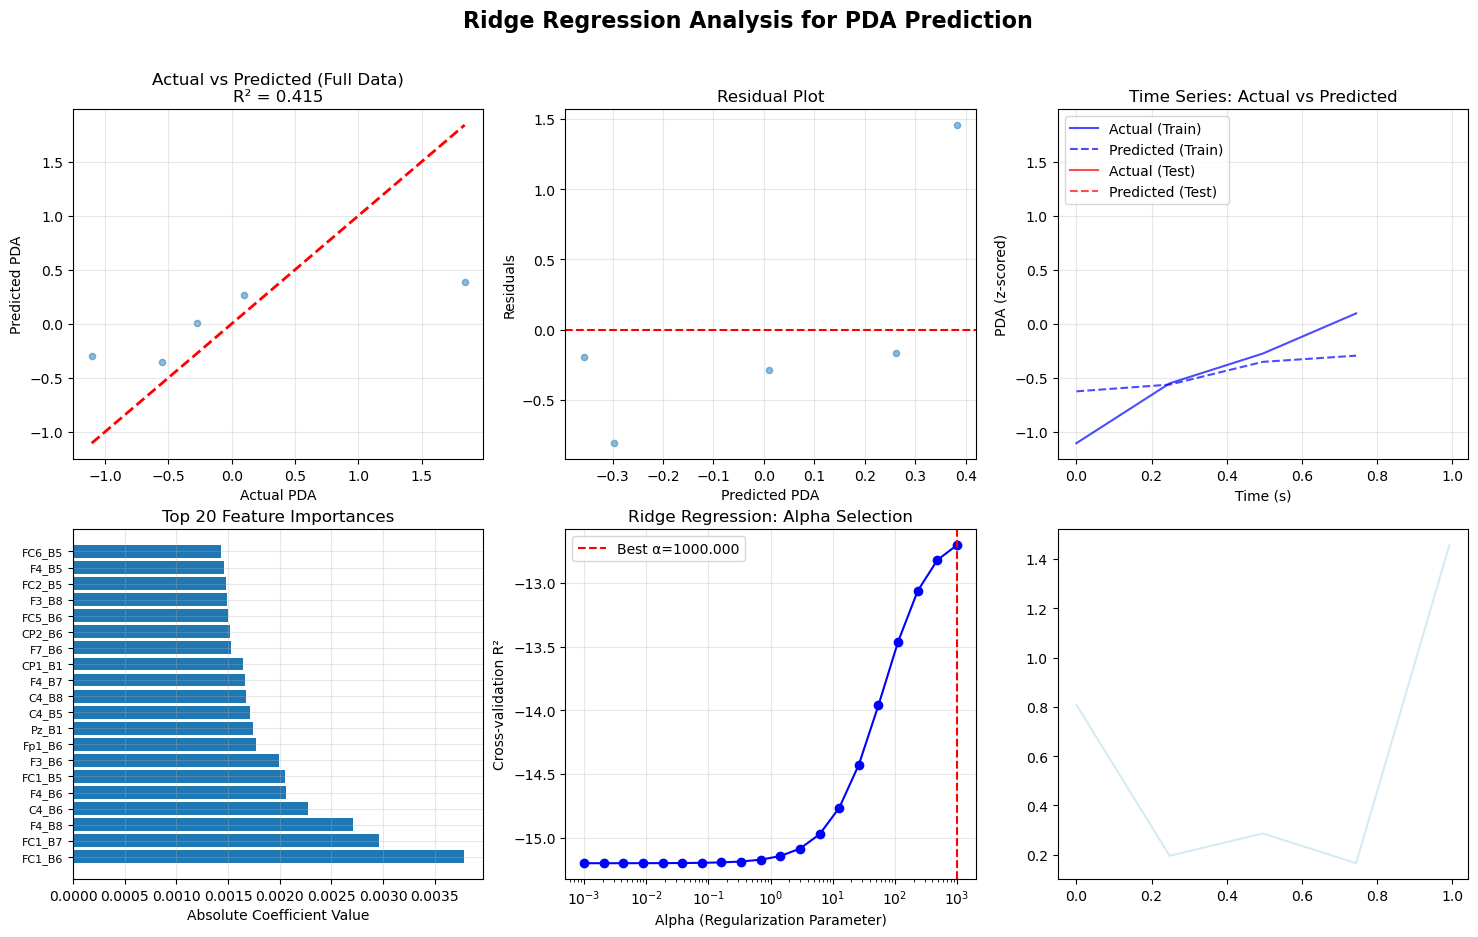

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns

## Step 9: Machine Learning - Ridge Regression for PDA Prediction

# Use the aligned data
X = aligned_data['X']
y = aligned_data['y']
feature_names = aligned_data['feature_names']
time_points = aligned_data['time']

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")

# 1. Basic Ridge Regression with Cross-Validation
print("\n" + "="*50)
print("RIDGE REGRESSION WITH CROSS-VALIDATION")
print("="*50)

# Fit model with automatic alpha selection
# Adjust CV folds based on sample size
cv_folds = min(5, max(2, n_samples // 50))
ridge = RidgeCV(alphas=np.logspace(-3, 3, 20), cv=cv_folds)
ridge.fit(X, y)

# Report basic metrics
r2 = ridge.score(X, y)
print(f"✅ Ridge Regression R² score: {r2:.3f}")
print(f"✅ Best alpha: {ridge.alpha_:.3f}")
print(f"✅ Used {cv_folds}-fold cross-validation")

# 2. Time Series Cross-Validation (more appropriate for temporal data)
print("\n" + "="*50)
print("TIME SERIES CROSS-VALIDATION")
print("="*50)

# Adaptive number of splits based on data size
n_samples = len(X)
max_splits = min(5, max(2, n_samples // 20))  # Ensure at least 2 splits

# Initialize cv_scores for later use
cv_scores = np.array([r2])  # Default to single score

if n_samples >= 40:  # Need enough samples for meaningful time series split
    # Use TimeSeriesSplit for temporal data
    tscv = TimeSeriesSplit(n_splits=max_splits)
    try:
        cv_scores = cross_val_score(ridge, X, y, cv=tscv, scoring='r2')
        print(f"Time Series CV with {max_splits} splits")
        print(f"R² scores: {cv_scores}")
        print(f"Mean R² (CV): {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    except Exception as e:
        print(f"⚠️ Time series CV failed: {str(e)}")
        cv_scores = np.array([r2])
else:
    print(f"⚠️ Limited samples ({n_samples}), using leave-one-out or simple validation")
    if n_samples >= 10:
        # For small datasets, use Leave-One-Out or 2-fold
        from sklearn.model_selection import LeaveOneOut
        loo = LeaveOneOut()
        try:
            cv_scores = cross_val_score(ridge, X, y, cv=min(n_samples, 3), scoring='r2')
            print(f"Small sample CV R²: {cv_scores.mean():.3f}")
        except:
            cv_scores = np.array([r2])
    else:
        print("⚠️ Too few samples for cross-validation, using training score only")
        cv_scores = np.array([r2])

# 3. Train-Test Split Analysis
print("\n" + "="*50)
print("TRAIN-TEST SPLIT ANALYSIS")
print("="*50)

# Use last 20% for testing
test_size = 0.2
split_idx = int(len(X) * (1 - test_size))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
time_train, time_test = time_points[:split_idx], time_points[split_idx:]

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# Train final model
ridge_final = Ridge(alpha=ridge.alpha_)
ridge_final.fit(X_train, y_train)

# Predictions
y_train_pred = ridge_final.predict(X_train)
y_test_pred = ridge_final.predict(X_test)

# Metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\nTraining Performance:")
print(f"  R²: {train_r2:.3f}")
print(f"  MSE: {train_mse:.3f}")
print(f"  MAE: {train_mae:.3f}")

print(f"\nTesting Performance:")
print(f"  R²: {test_r2:.3f}")
print(f"  MSE: {test_mse:.3f}")
print(f"  MAE: {test_mae:.3f}")

# 4. Feature Importance Analysis
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Get absolute coefficients
feature_importance = np.abs(ridge_final.coef_)
top_features_idx = np.argsort(feature_importance)[-20:][::-1]

print(f"\nTop 10 Most Important Features:")
for i, idx in enumerate(top_features_idx[:10]):
    print(f"{i+1}. {feature_names[idx]}: {ridge_final.coef_[idx]:.3f}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Ridge Regression Analysis for PDA Prediction', fontsize=16, fontweight='bold')

# 1. Actual vs Predicted (Full dataset)
ax = axes[0, 0]
y_full_pred = ridge.predict(X)
ax.scatter(y, y_full_pred, alpha=0.5, s=20)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
ax.set_xlabel('Actual PDA')
ax.set_ylabel('Predicted PDA')
ax.set_title(f'Actual vs Predicted (Full Data)\nR² = {r2:.3f}')
ax.grid(True, alpha=0.3)

# 2. Residuals Plot
ax = axes[0, 1]
residuals = y - y_full_pred
ax.scatter(y_full_pred, residuals, alpha=0.5, s=20)
ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel('Predicted PDA')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
ax.grid(True, alpha=0.3)

# 3. Time Series Prediction
ax = axes[0, 2]
ax.plot(time_train, y_train, 'b-', label='Actual (Train)', alpha=0.7)
ax.plot(time_train, y_train_pred, 'b--', label='Predicted (Train)', alpha=0.7)
ax.plot(time_test, y_test, 'r-', label='Actual (Test)', alpha=0.7)
ax.plot(time_test, y_test_pred, 'r--', label='Predicted (Test)', alpha=0.7)
ax.set_xlabel('Time (s)')
ax.set_ylabel('PDA (z-scored)')
ax.set_title('Time Series: Actual vs Predicted')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Feature Importance Bar Plot
ax = axes[1, 0]
bars = ax.barh(range(len(top_features_idx)), feature_importance[top_features_idx])
ax.set_yticks(range(len(top_features_idx)))
ax.set_yticklabels([feature_names[idx].split('_')[0] + '_B' + 
                   feature_names[idx].split('Band')[1].split('_')[0] 
                   for idx in top_features_idx], fontsize=8)
ax.set_xlabel('Absolute Coefficient Value')
ax.set_title('Top 20 Feature Importances')
ax.grid(True, alpha=0.3)

# 5. Cross-validation scores
ax = axes[1, 1]
cv_scores_all = []
alphas = np.logspace(-3, 3, 20)

# Determine appropriate CV strategy based on sample size
if n_samples >= 50:
    cv_strategy = 5
elif n_samples >= 30:
    cv_strategy = 3
else:
    cv_strategy = 2

print(f"\nUsing {cv_strategy}-fold CV for alpha selection (n_samples={n_samples})")

for alpha in alphas:
    ridge_cv = Ridge(alpha=alpha)
    try:
        scores = cross_val_score(ridge_cv, X, y, cv=cv_strategy, scoring='r2')
        cv_scores_all.append(scores.mean())
    except:
        # If CV fails, use training score
        ridge_cv.fit(X, y)
        cv_scores_all.append(ridge_cv.score(X, y))

ax.semilogx(alphas, cv_scores_all, 'b-', marker='o')
ax.axvline(x=ridge.alpha_, color='r', linestyle='--', label=f'Best α={ridge.alpha_:.3f}')
ax.set_xlabel('Alpha (Regularization Parameter)')
ax.set_ylabel('Cross-validation R²')
ax.set_title('Ridge Regression: Alpha Selection')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Prediction Error Over Time
ax = axes[1, 2]
prediction_error = np.abs(y - y_full_pred)
window_size = max(10, len(y) // 50)  # Adaptive window size
smoothed_error = np.convolve(prediction_error, np.ones(window_size)/window_size, mode='valid')
smooth_time = time_points[:len(smoothed_error)]

ax.plot(time_points, prediction_error, 'lightblue', alpha=0.5, label='Raw error')
ax.plot(smooth_time, smoothed_error, 'darkblue', linewidth=2, label='Smoothed error')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Absolute Prediction Error')
ax.set_title('Prediction Error Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature contribution analysis
print("\n" + "="*50)
print("FEATURE CONTRIBUTION ANALYSIS")
print("="*50)

# Group features by channel and band
channel_contributions = {}
band_contributions = {}

for i, feat_name in enumerate(feature_names):
    channel = feat_name.split('_')[0]
    band_match = feat_name.split('Band')[1].split('_')[0]
    
    if channel not in channel_contributions:
        channel_contributions[channel] = []
    channel_contributions[channel].append(np.abs(ridge_final.coef_[i]))
    
    if band_match not in band_contributions:
        band_contributions[band_match] = []
    band_contributions[band_match].append(np.abs(ridge_final.coef_[i]))

# Calculate average contributions
avg_channel_contrib = {ch: np.mean(contribs) for ch, contribs in channel_contributions.items()}
avg_band_contrib = {band: np.mean(contribs) for band, contribs in band_contributions.items()}

# Sort and print
print("\nTop 5 Contributing Channels:")
for ch, contrib in sorted(avg_channel_contrib.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"  {ch}: {contrib:.4f}")

print("\nContribution by Frequency Band:")
for band, contrib in sorted(avg_band_contrib.items(), key=lambda x: int(x[0])):
    print(f"  Band {band}: {contrib:.4f}")

# Save model and results
model_results = {
    'model': ridge_final,
    'alpha': ridge.alpha_,
    'coefficients': ridge_final.coef_,
    'intercept': ridge_final.intercept_,
    'feature_names': feature_names,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'cv_scores': cv_scores,
    'predictions': {
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'y_full_pred': y_full_pred
    }
}

print(f"\n✅ Model training complete!")
print(f"   Overall R²: {r2:.3f}")
print(f"   Test R²: {test_r2:.3f}")
print(f"   Best alpha: {ridge.alpha_:.3f}")

## Step 7: Train Ridge Regression Model Small Datasets use with caution


Dataset shape: X=(5, 248), y=(5,)
Features: 248, Samples: 5

⚠️ WARNING: Very limited data (5 samples)
   With 248 features, this is severely underdetermined
   Results should be interpreted with extreme caution!

SIMPLE RIDGE REGRESSION ANALYSIS
Alpha=  0.001: R²=1.000, MSE=0.000, Active features=248
Alpha=  0.010: R²=1.000, MSE=0.000, Active features=248
Alpha=  0.100: R²=1.000, MSE=0.000, Active features=248
Alpha=  1.000: R²=1.000, MSE=0.000, Active features=248
Alpha= 10.000: R²=0.996, MSE=0.004, Active features=248
Alpha=100.000: R²=0.869, MSE=0.131, Active features=248
Alpha=1000.000: R²=0.415, MSE=0.585, Active features=248

✅ Selected alpha: 0.001
   R² score: 1.000
   Active features: 248

Top 10 Features:
1. Fp1_Band1_0.0-1.0Hz: -0.044
2. Pz_Band1_0.0-1.0Hz: -0.042
3. Fz_Band8_13.0-125.0Hz: 0.038
4. FC1_Band6_7.0-9.0Hz: -0.036
5. Fp1_Band3_2.0-3.0Hz: 0.033
6. F3_Band8_13.0-125.0Hz: 0.028
7. FC6_Band5_5.0-7.0Hz: -0.026
8. Fp2_Band4_3.0-5.0Hz: -0.026
9. Fp1_Band2_1.0-2.0Hz: 0.

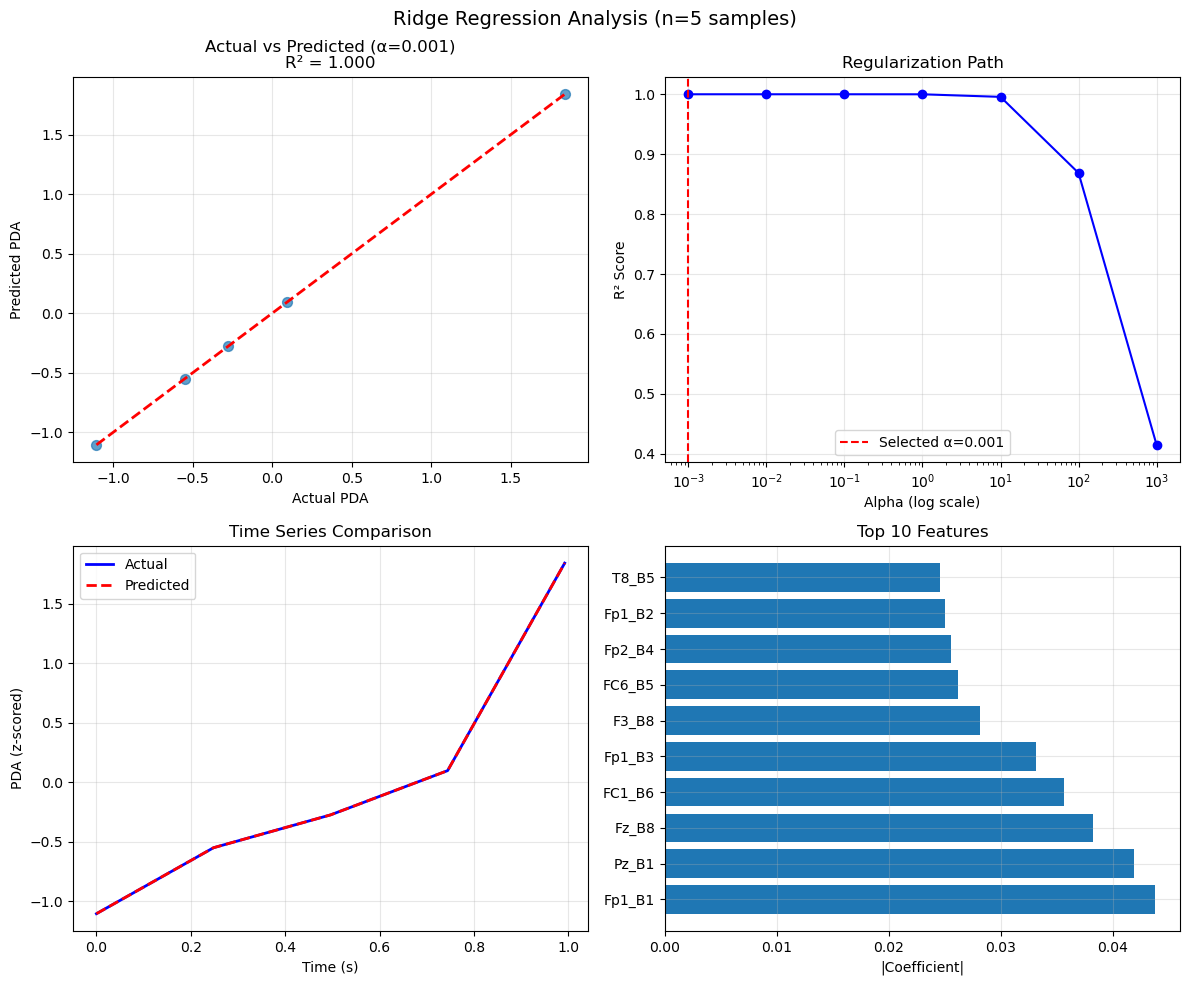


SUMMARY
Sample size: 5
Feature count: 248
Features/Sample ratio: 49.6

⚠️ SEVERE OVERFITTING RISK!
   You have 248 features but only 5 samples
   Consider:
   - Collecting more data (at least 496 samples)
   - Using stronger regularization (higher alpha)
   - Reducing features to top 2

SIMPLE CORRELATION ANALYSIS
Top 5 individual feature correlations with PDA:
  C3_Band2_1.0-2.0Hz: r=0.995
  F7_Band4_3.0-5.0Hz: r=-0.971
  CP1_Band5_5.0-7.0Hz: r=0.955
  C4_Band4_3.0-5.0Hz: r=-0.934
  T7_Band5_5.0-7.0Hz: r=-0.919

RAW DATA (due to small sample size)
Sample | PDA    | Top Feature
----------------------------------------
     1 | -1.107 | -0.646
     2 | -0.552 | -0.524
     3 | -0.276 | -0.511
     4 |  0.096 | -0.370
     5 |  1.840 | -0.043

💡 Recommendation: Collect more data for reliable machine learning results!


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

## Ridge Regression for Small/Limited Datasets

# Use the aligned data
X = aligned_data['X']
y = aligned_data['y']
feature_names = aligned_data['feature_names']
time_points = aligned_data['time']

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")

# Check if we have enough data
n_samples = len(X)
n_features = X.shape[1]

if n_samples < 10:
    print(f"\n⚠️ WARNING: Very limited data ({n_samples} samples)")
    print(f"   With {n_features} features, this is severely underdetermined")
    print(f"   Results should be interpreted with extreme caution!")

# For very small datasets, use simple approaches
print("\n" + "="*50)
print("SIMPLE RIDGE REGRESSION ANALYSIS")
print("="*50)

# Try different alpha values
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
results = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    y_pred = ridge.predict(X)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    
    # Count non-zero coefficients
    non_zero = np.sum(np.abs(ridge.coef_) > 1e-6)
    
    results.append({
        'alpha': alpha,
        'r2': r2,
        'mse': mse,
        'non_zero_coefs': non_zero,
        'model': ridge
    })
    
    print(f"Alpha={alpha:7.3f}: R²={r2:.3f}, MSE={mse:.3f}, Active features={non_zero}")

# Find best alpha based on simplicity vs performance trade-off
best_result = max(results, key=lambda x: x['r2'] - 0.01 * x['non_zero_coefs'])
best_model = best_result['model']
best_alpha = best_result['alpha']

print(f"\n✅ Selected alpha: {best_alpha}")
print(f"   R² score: {best_result['r2']:.3f}")
print(f"   Active features: {best_result['non_zero_coefs']}")

# Feature importance
feature_importance = np.abs(best_model.coef_)
top_features_idx = np.argsort(feature_importance)[-min(10, n_features):][::-1]

print(f"\nTop {len(top_features_idx)} Features:")
for i, idx in enumerate(top_features_idx):
    if feature_importance[idx] > 1e-6:
        print(f"{i+1}. {feature_names[idx]}: {best_model.coef_[idx]:.3f}")

# Visualization for small datasets
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f'Ridge Regression Analysis (n={n_samples} samples)', fontsize=14)

# 1. Actual vs Predicted
ax = axes[0, 0]
y_pred = best_model.predict(X)
ax.scatter(y, y_pred, s=50, alpha=0.7)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
ax.set_xlabel('Actual PDA')
ax.set_ylabel('Predicted PDA')
ax.set_title(f'Actual vs Predicted (α={best_alpha})\nR² = {best_result["r2"]:.3f}')
ax.grid(True, alpha=0.3)

# 2. Alpha vs R²
ax = axes[0, 1]
alphas_plot = [r['alpha'] for r in results]
r2_scores = [r['r2'] for r in results]
ax.semilogx(alphas_plot, r2_scores, 'b-o')
ax.axvline(x=best_alpha, color='r', linestyle='--', label=f'Selected α={best_alpha}')
ax.set_xlabel('Alpha (log scale)')
ax.set_ylabel('R² Score')
ax.set_title('Regularization Path')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Time series (if applicable)
ax = axes[1, 0]
if n_samples > 1:
    ax.plot(time_points, y, 'b-', label='Actual', linewidth=2)
    ax.plot(time_points, y_pred, 'r--', label='Predicted', linewidth=2)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('PDA (z-scored)')
    ax.set_title('Time Series Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Too few samples for time series', 
            ha='center', va='center', transform=ax.transAxes)

# 4. Feature importance (top features only)
ax = axes[1, 1]
if len(top_features_idx) > 0:
    feature_names_short = [f.split('_')[0] + '_B' + f.split('Band')[1].split('_')[0] 
                          for f in [feature_names[i] for i in top_features_idx]]
    importance_values = feature_importance[top_features_idx]
    
    bars = ax.barh(range(len(top_features_idx)), importance_values)
    ax.set_yticks(range(len(top_features_idx)))
    ax.set_yticklabels(feature_names_short)
    ax.set_xlabel('|Coefficient|')
    ax.set_title(f'Top {len(top_features_idx)} Features')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(f"Sample size: {n_samples}")
print(f"Feature count: {n_features}")
print(f"Features/Sample ratio: {n_features/n_samples:.1f}")

if n_samples < n_features:
    print(f"\n⚠️ SEVERE OVERFITTING RISK!")
    print(f"   You have {n_features} features but only {n_samples} samples")
    print(f"   Consider:")
    print(f"   - Collecting more data (at least {n_features * 2} samples)")
    print(f"   - Using stronger regularization (higher alpha)")
    print(f"   - Reducing features to top {max(1, n_samples // 2)}")

# Simple correlation analysis as alternative
print("\n" + "="*50)
print("SIMPLE CORRELATION ANALYSIS")
print("="*50)

correlations = aligned_data['correlations']
top_corr_idx = np.argsort(np.abs(correlations))[-5:][::-1]

print("Top 5 individual feature correlations with PDA:")
for idx in top_corr_idx:
    print(f"  {feature_names[idx]}: r={correlations[idx]:.3f}")

# If very few samples, show the actual data
if n_samples <= 10:
    print("\n" + "="*50)
    print("RAW DATA (due to small sample size)")
    print("="*50)
    print("Sample | PDA    | Top Feature")
    print("-" * 40)
    top_feature_data = X[:, top_corr_idx[0]]
    for i in range(n_samples):
        print(f"{i+1:6d} | {y[i]:6.3f} | {top_feature_data[i]:6.3f}")

print("\n💡 Recommendation: Collect more data for reliable machine learning results!")

## 1. Visualize Actual vs. Predicted PDA



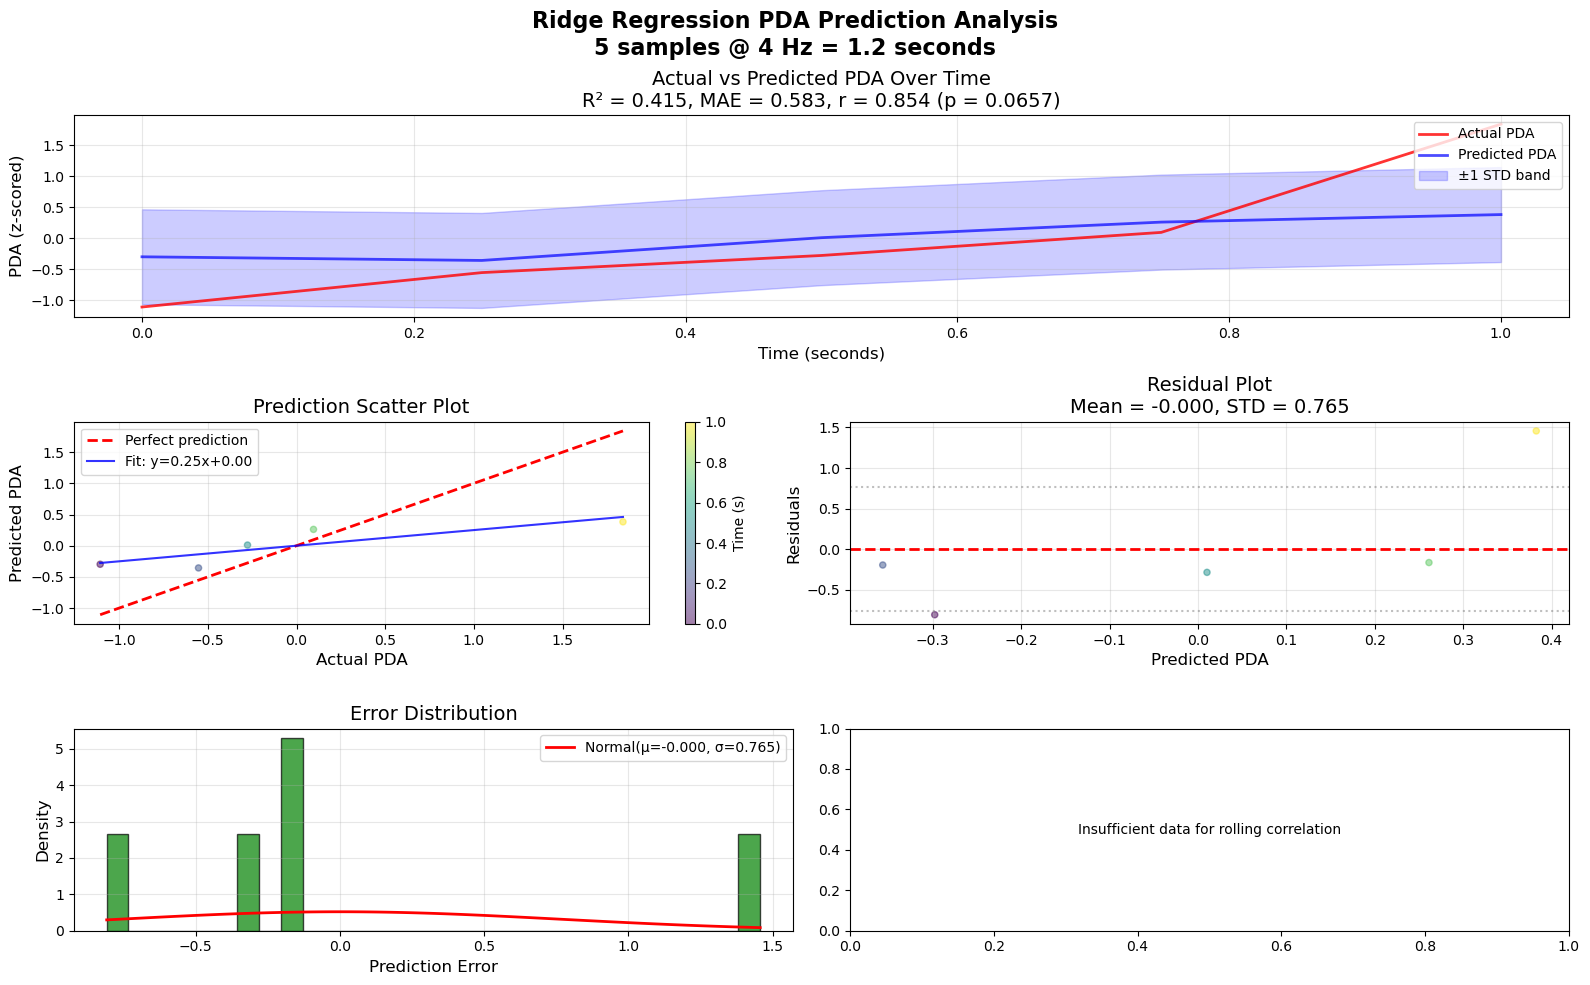

PREDICTION PERFORMANCE SUMMARY
R² Score: 0.4149
Pearson Correlation: 0.8537 (p=6.5685e-02)
Mean Absolute Error: 0.5829
Root Mean Square Error: 0.7649
Mean Prediction: 0.0000 (Actual: -0.0000)
STD Prediction: 0.2934 (Actual: 1.0000)

PREDICTION QUALITY ANALYSIS

Periods of large prediction error (>80th percentile):
  1.0s - 1.0s (mean error: 1.457)

KEY PREDICTIVE FEATURES

Top 10 features by absolute coefficient:
1. Fz_Band7_9.0-13.0Hz
   Coefficient: -0.0077
   Contribution STD: 0.0279
2. O2_Band3_2.0-3.0Hz
   Coefficient: -0.0065
   Contribution STD: 0.0185
3. FC1_Band5_5.0-7.0Hz
   Coefficient: -0.0065
   Contribution STD: 0.0160
4. Fz_Band6_7.0-9.0Hz
   Coefficient: -0.0062
   Contribution STD: 0.0188
5. Fp2_Band3_2.0-3.0Hz
   Coefficient: -0.0060
   Contribution STD: 0.0226
6. FC1_Band7_9.0-13.0Hz
   Coefficient: -0.0053
   Contribution STD: 0.0158
7. F7_Band9_125.0-125.0Hz
   Coefficient: -0.0051
   Contribution STD: 0.0090
8. F3_Band9_125.0-125.0Hz
   Coefficient: -0.0044
   Con

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import pearsonr

## Enhanced Prediction Visualization

# Make predictions
y_pred = ridge.predict(X_aligned)

# Calculate metrics
r2 = r2_score(y_aligned, y_pred)
mae = mean_absolute_error(y_aligned, y_pred)
correlation, p_value = pearsonr(y_aligned, y_pred)

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 10))

# Main plot: Time series comparison
ax1 = plt.subplot(3, 2, (1, 2))
time_axis = np.arange(len(y_aligned)) / 4  # Convert to seconds (4 Hz sampling)

plt.plot(time_axis, y_aligned, label='Actual PDA', color='red', linewidth=2, alpha=0.8)
plt.plot(time_axis, y_pred, label='Predicted PDA', color='blue', linewidth=2, alpha=0.7)

# Add confidence band (based on prediction error)
error = y_aligned - y_pred
rolling_std = pd.Series(error).rolling(window=20, center=True).std().fillna(error.std())
plt.fill_between(time_axis, y_pred - rolling_std, y_pred + rolling_std, 
                 color='blue', alpha=0.2, label='±1 STD band')

plt.title(f'Actual vs Predicted PDA Over Time\nR² = {r2:.3f}, MAE = {mae:.3f}, r = {correlation:.3f} (p = {p_value:.4f})', 
          fontsize=14)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('PDA (z-scored)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Scatter plot: Actual vs Predicted
ax2 = plt.subplot(3, 2, 3)
plt.scatter(y_aligned, y_pred, alpha=0.5, s=20, c=time_axis, cmap='viridis')
plt.plot([y_aligned.min(), y_aligned.max()], [y_aligned.min(), y_aligned.max()], 
         'r--', lw=2, label='Perfect prediction')

# Add regression line
z = np.polyfit(y_aligned, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_aligned, p(y_aligned), "b-", alpha=0.8, label=f'Fit: y={z[0]:.2f}x+{z[1]:.2f}')

plt.xlabel('Actual PDA', fontsize=12)
plt.ylabel('Predicted PDA', fontsize=12)
plt.title(f'Prediction Scatter Plot', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.colorbar(label='Time (s)')

# Residual plot
ax3 = plt.subplot(3, 2, 4)
residuals = y_aligned - y_pred
plt.scatter(y_pred, residuals, alpha=0.5, s=20, c=time_axis, cmap='viridis')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.axhline(y=residuals.std(), color='gray', linestyle=':', alpha=0.5)
plt.axhline(y=-residuals.std(), color='gray', linestyle=':', alpha=0.5)

plt.xlabel('Predicted PDA', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title(f'Residual Plot\nMean = {residuals.mean():.3f}, STD = {residuals.std():.3f}', fontsize=14)
plt.grid(True, alpha=0.3)

# Error distribution
ax4 = plt.subplot(3, 2, 5)
plt.hist(residuals, bins=30, density=True, alpha=0.7, color='green', edgecolor='black')

# Fit normal distribution
from scipy import stats
mu, sigma = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, 
         label=f'Normal(μ={mu:.3f}, σ={sigma:.3f})')

plt.xlabel('Prediction Error', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Error Distribution', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Rolling correlation
ax5 = plt.subplot(3, 2, 6)
window_size = min(40, len(y_aligned) // 4)  # 10 seconds at 4 Hz or adaptive
if window_size > 10:
    rolling_corr = []
    for i in range(len(y_aligned) - window_size):
        window_actual = y_aligned[i:i+window_size]
        window_pred = y_pred[i:i+window_size]
        if np.std(window_actual) > 0 and np.std(window_pred) > 0:
            corr = np.corrcoef(window_actual, window_pred)[0, 1]
            rolling_corr.append(corr)
        else:
            rolling_corr.append(np.nan)
    
    rolling_time = time_axis[window_size//2:window_size//2 + len(rolling_corr)]
    plt.plot(rolling_time, rolling_corr, linewidth=2, color='purple')
    plt.axhline(y=correlation, color='red', linestyle='--', 
                label=f'Overall r={correlation:.3f}')
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Correlation', fontsize=12)
    plt.title(f'Rolling Correlation (window={window_size/4:.1f}s)', fontsize=14)
    plt.ylim(-1, 1)
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Insufficient data for rolling correlation', 
             ha='center', va='center', transform=ax5.transAxes)

plt.suptitle(f'Ridge Regression PDA Prediction Analysis\n{len(y_aligned)} samples @ 4 Hz = {len(y_aligned)/4:.1f} seconds', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed statistics
print("="*60)
print("PREDICTION PERFORMANCE SUMMARY")
print("="*60)
print(f"R² Score: {r2:.4f}")
print(f"Pearson Correlation: {correlation:.4f} (p={p_value:.4e})")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Square Error: {np.sqrt(np.mean(residuals**2)):.4f}")
print(f"Mean Prediction: {y_pred.mean():.4f} (Actual: {y_aligned.mean():.4f})")
print(f"STD Prediction: {y_pred.std():.4f} (Actual: {y_aligned.std():.4f})")

# Identify periods of good/poor prediction
print("\n" + "="*60)
print("PREDICTION QUALITY ANALYSIS")
print("="*60)

abs_error = np.abs(residuals)
threshold = np.percentile(abs_error, 80)  # Top 20% errors

print(f"\nPeriods of large prediction error (>80th percentile):")
high_error_mask = abs_error > threshold
if np.any(high_error_mask):
    # Find continuous segments
    diff = np.diff(np.concatenate(([0], high_error_mask.astype(int), [0])))
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]
    
    for start, end in zip(starts[:5], ends[:5]):  # Show first 5
        print(f"  {time_axis[start]:.1f}s - {time_axis[end-1]:.1f}s "
              f"(mean error: {abs_error[start:end].mean():.3f})")

# Feature contribution to prediction
print("\n" + "="*60)
print("KEY PREDICTIVE FEATURES")
print("="*60)

# Get top contributing features
feature_importance = np.abs(ridge.coef_)
top_n = 10
top_idx = np.argsort(feature_importance)[-top_n:][::-1]

print(f"\nTop {top_n} features by absolute coefficient:")
for i, idx in enumerate(top_idx):
    feature_contribution = X_aligned[:, idx] * ridge.coef_[idx]
    contrib_std = np.std(feature_contribution)
    print(f"{i+1}. {ml_features['feature_names'][idx]}")
    print(f"   Coefficient: {ridge.coef_[idx]:.4f}")
    print(f"   Contribution STD: {contrib_std:.4f}")

## 2. Inspect Model Coefficients

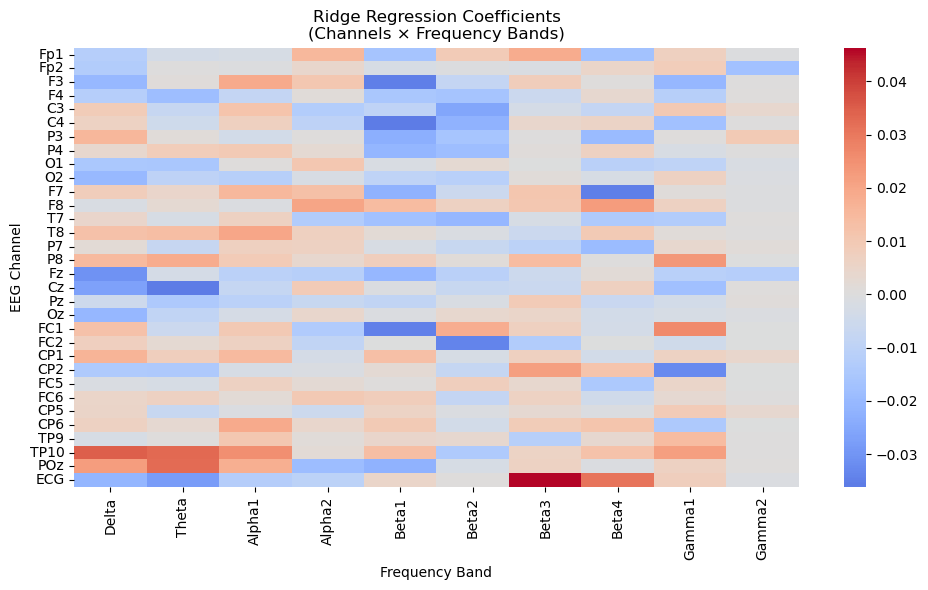

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define band labels
band_labels = [
    "Delta", "Theta", "Alpha1", "Alpha2",
    "Beta1", "Beta2", "Beta3", "Beta4",
    "Gamma1", "Gamma2"
]

# Reshape coefficients to (channels, bands)
coefs = ridge.coef_.reshape(n_channels, n_bands)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(coefs, xticklabels=band_labels,
            yticklabels=raw.ch_names[:n_channels],
            cmap='coolwarm', center=0)

plt.title('Ridge Regression Coefficients\n(Channels × Frequency Bands)')
plt.xlabel('Frequency Band')
plt.ylabel('EEG Channel')
plt.tight_layout()
plt.show()


## Top Contributing Channels and Frequencies


1. Reshape and Rank Absolute Coefficients

In [69]:
# Reshape back to (channels, 10 bands)
coefs = ridge.coef_.reshape(n_channels, n_bands)

# Compute absolute weight for ranking
abs_coefs = np.abs(coefs)

# Rank all channel × band pairs by contribution
flat_indices = np.argsort(abs_coefs.ravel())[::-1]
ranked = [(raw.ch_names[i // n_bands], f'Band {i % n_bands + 1}', coefs[i // n_bands, i % n_bands])
          for i in flat_indices]
# EEG band labels (assuming bands were defined roughly in this order)
band_labels = [
    "Delta", "Theta", "Alpha1", "Alpha2",
    "Beta1", "Beta2", "Beta3", "Beta4",
    "Gamma1", "Gamma2"
]

# Reshape back to (channels, 10 bands)
coefs = ridge.coef_.reshape(n_channels, n_bands)

# Compute absolute weight for ranking
abs_coefs = np.abs(coefs)

# Rank all channel × band pairs by contribution
flat_indices = np.argsort(abs_coefs.ravel())[::-1]
ranked = [(raw.ch_names[i // n_bands], band_labels[i % n_bands], coefs[i // n_bands, i % n_bands])
          for i in flat_indices]


2. Display Top 10 Contributors

In [70]:
print("🔝 Top 10 contributing channel × frequency band pairs:")
for i, (ch, band, weight) in enumerate(ranked[:10], 1):
    print(f"{i}. {ch} — {band} → Coefficient = {weight:.4f}")


🔝 Top 10 contributing channel × frequency band pairs:
1. ECG — Beta3 → Coefficient = 0.0463
2. Cz — Theta → Coefficient = -0.0362
3. C4 — Beta1 → Coefficient = -0.0358
4. F3 — Beta1 → Coefficient = -0.0352
5. F7 — Beta4 → Coefficient = -0.0351
6. FC1 — Beta1 → Coefficient = -0.0348
7. TP10 — Delta → Coefficient = 0.0348
8. FC2 — Beta2 → Coefficient = -0.0339
9. TP10 — Theta → Coefficient = 0.0331
10. POz — Theta → Coefficient = 0.0327


3. Optional: Grouped Summaries
▶️ Top Channels (aggregated over bands)

In [71]:
channel_scores = abs_coefs.sum(axis=1)
top_channels = np.argsort(channel_scores)[::-1]

print("\n🎯 Top 5 contributing EEG channels (sum across bands):")
for i in range(5):
    ch = raw.ch_names[top_channels[i]]
    score = channel_scores[top_channels[i]]
    print(f"{i+1}. {ch} → Total |weight| = {score:.4f}")



🎯 Top 5 contributing EEG channels (sum across bands):
1. ECG → Total |weight| = 0.1634
2. TP10 → Total |weight| = 0.1628
3. FC1 → Total |weight| = 0.1320
4. POz → Total |weight| = 0.1305
5. F3 → Total |weight| = 0.1230


 Top Frequency Bands (aggregated over channels)

In [72]:
# Sum of absolute weights per frequency band across all channels
band_scores = abs_coefs.sum(axis=0)
top_bands = np.argsort(band_scores)[::-1]

print("\n🎯 Top 5 contributing frequency bands (sum across channels):")
for i in range(5):
    band_name = band_labels[top_bands[i]]
    score = band_scores[top_bands[i]]
    print(f"{i+1}. {band_name} → Total |weight| = {score:.4f}")


🎯 Top 5 contributing frequency bands (sum across channels):
1. Delta → Total |weight| = 0.4029
2. Beta1 → Total |weight| = 0.3872
3. Gamma1 → Total |weight| = 0.3309
4. Theta → Total |weight| = 0.3261
5. Beta2 → Total |weight| = 0.2984


Topomap of Ridge Coefficients for One Band

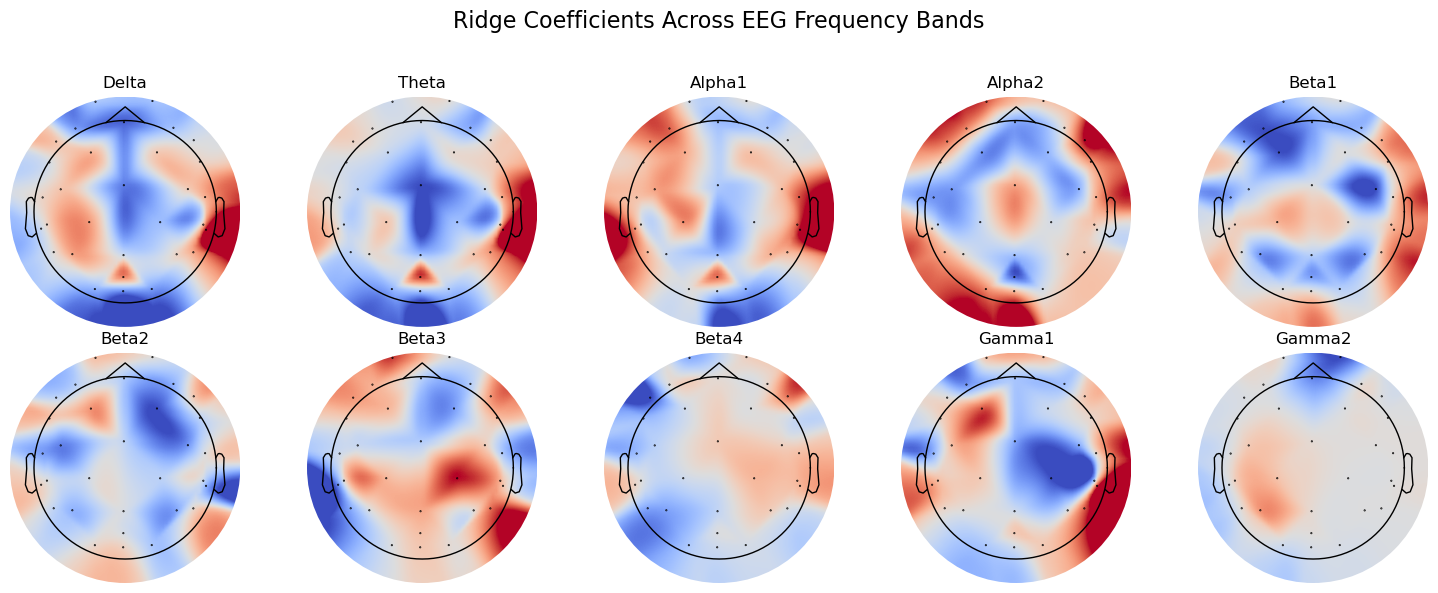

In [73]:
from mne.viz import plot_topomap
import matplotlib.pyplot as plt
import numpy as np

# Make sure montage and coefs are valid
montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage, on_missing='ignore')
picks_eeg = mne.pick_types(raw.info, eeg=True)

# Get channel positions and filter valid ones
valid_pos = []
valid_idx = []
for i in picks_eeg:
    pos_2d = raw.info['chs'][i]['loc'][:2]
    if not np.any(np.isnan(pos_2d)):
        valid_pos.append(pos_2d)
        valid_idx.append(i)

valid_pos = np.array(valid_pos)
coefs_valid = coefs[valid_idx, :]

# Band labels
band_labels = [
    "Delta", "Theta", "Alpha1", "Alpha2",
    "Beta1", "Beta2", "Beta3", "Beta4",
    "Gamma1", "Gamma2"
]

# Grid plot of all bands
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

for i in range(len(band_labels)):
    ax = axs[i]
    weights = coefs_valid[:, i]
    plot_topomap(weights, valid_pos, axes=ax, show=False, contours=0, cmap="coolwarm")
    ax.set_title(band_labels[i])

fig.suptitle("Ridge Coefficients Across EEG Frequency Bands", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [74]:
# Print frequency ranges for each of the 10 bands
print("🎼 Frequency Ranges of EEG Bands:")
for i in range(len(band_edges) - 1):
    f_start = freqs[band_edges[i]]
    f_end = freqs[band_edges[i+1] - 1] if band_edges[i+1] < len(freqs) else freqs[-1]
    print(f"{band_labels[i]}: {f_start:.1f}–{f_end:.1f} Hz")


🎼 Frequency Ranges of EEG Bands:
Delta: 0.0–0.0 Hz
Theta: 1.0–1.0 Hz
Alpha1: 2.0–3.0 Hz
Alpha2: 4.0–6.0 Hz
Beta1: 7.0–10.0 Hz
Beta2: 11.0–12.0 Hz
Beta3: 13.0–13.0 Hz
Beta4: 14.0–15.0 Hz
Gamma1: 16.0–124.0 Hz


## Delay Embedding for EEG Features


## Nested Cross-Validation Setup



✅ Nested CV Summary:
Mean R²:        -5.667
Mean NMSE:      6.667
Mean Pearson r: 0.030
Best λ per fold: [0.004641588833612777, 2.154434690031882, 0.004641588833612777, 0.021544346900318832, 0.004641588833612777, 10.0, 0.021544346900318832, 0.021544346900318832, 2.154434690031882, 2.154434690031882]
Mean log₁₀(λ):   -1.00


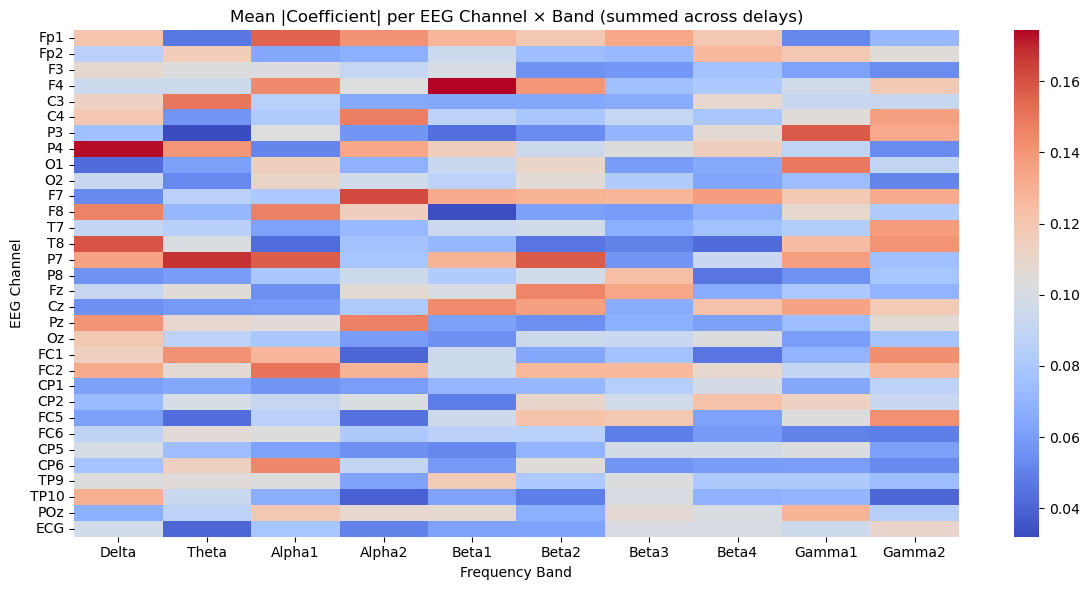

In [75]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
m, k = 2, 5      # outer loop: 2×5 = 10 folds
n = 30           # inner loop: 30 random splits for lambda search
lambdas = np.logspace(-3, 3, 10)

# Storage for outer loop
outer_r2_scores = []
outer_nmse_scores = []
outer_corr_scores = []
best_lambdas = []
all_coefs = []

# Outer cross-validation: m×k = 10 folds with time-blocked sampling
block_size = len(y_with_delays) // (m * k)
block_indices = [np.arange(i * block_size, (i + 1) * block_size) for i in range(m * k)]

for outer_idx in range(m * k):
    test_idx = block_indices[outer_idx]
    train_idx = np.hstack([block_indices[i] for i in range(m * k) if i != outer_idx])

    X_train, X_test = X_with_delays[train_idx], X_with_delays[test_idx]
    y_train, y_test = y_with_delays[train_idx], y_with_delays[test_idx]

    # Inner CV for best lambda selection
    best_lambda = None
    best_nmse = np.inf

    for lam in lambdas:
        nmse_list = []
        for _ in range(n):
            X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.2)
            model = Ridge(alpha=lam)
            model.fit(X_subtrain, y_subtrain)
            y_pred = model.predict(X_val)

            mse = mean_squared_error(y_val, y_pred)
            var = np.var(y_val)
            nmse = mse / var
            nmse_list.append(nmse)

        mean_nmse = np.mean(nmse_list)
        if mean_nmse < best_nmse:
            best_nmse = mean_nmse
            best_lambda = lam

    best_lambdas.append(best_lambda)

    # Train on full train set with best lambda
    final_model = Ridge(alpha=best_lambda)
    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_test)

    # Store results
    outer_r2_scores.append(r2_score(y_test, y_pred))
    outer_nmse_scores.append(mean_squared_error(y_test, y_pred) / np.var(y_test))
    outer_corr_scores.append(pearsonr(y_test, y_pred)[0])
    all_coefs.append(final_model.coef_)

# ===== Results Summary =====
print("\n✅ Nested CV Summary:")
print(f"Mean R²:        {np.mean(outer_r2_scores):.3f}")
print(f"Mean NMSE:      {np.mean(outer_nmse_scores):.3f}")
print(f"Mean Pearson r: {np.mean(outer_corr_scores):.3f}")
print(f"Best λ per fold: {best_lambdas}")
print(f"Mean log₁₀(λ):   {np.mean(np.log10(best_lambdas)):.2f}")

# ===== Coefficient Summary (per EEG channel × band) =====

# Assuming you used delay embedding: (channels × bands × delays)
n_features = X_with_delays.shape[1]
n_channels = 32           # update if needed
n_bands = 10
n_delays = n_features // (n_channels * n_bands)

# Mean coefficients across folds
all_coefs = np.array(all_coefs)  # shape: (folds, n_features)
mean_coefs = all_coefs.mean(axis=0)

# Reshape to 3D: (channels, bands, delays)
coefs_3d = mean_coefs.reshape(n_channels, n_bands, n_delays)

# Collapse across delays → get total contribution per channel × band
coefs_sum = np.abs(coefs_3d).sum(axis=2)  # shape: (channels, bands)

# Plot heatmap
band_labels = ["Delta", "Theta", "Alpha1", "Alpha2", "Beta1",
               "Beta2", "Beta3", "Beta4", "Gamma1", "Gamma2"]

plt.figure(figsize=(12, 6))
sns.heatmap(coefs_sum, xticklabels=band_labels, yticklabels=raw.ch_names[:n_channels], cmap="coolwarm")
plt.title("Mean |Coefficient| per EEG Channel × Band (summed across delays)")
plt.xlabel("Frequency Band")
plt.ylabel("EEG Channel")
plt.tight_layout()
plt.show()


## FDR Correction (Benjamini–Hochberg)


✅ FDR Correction completed — 2011 significant weights (of 2880)
Example corrected p-value range: min=0.00000, max=0.99553


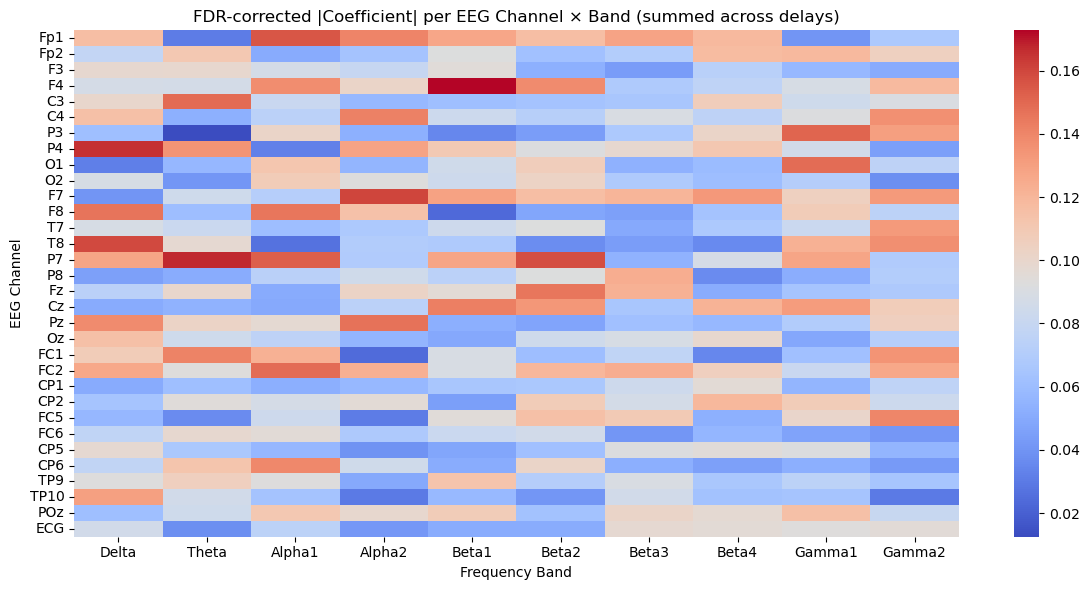

In [76]:
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ttest_1samp

# --- FDR Correction on Ridge Coefficients ---

# Step 1: t-test across folds to get p-values
t_vals, p_vals = ttest_1samp(all_coefs, popmean=0, axis=0)  # shape: (n_features,)

# Step 2: FDR correction
significant_mask, pvals_corrected = fdrcorrection(p_vals, alpha=0.05)

print(f"\n✅ FDR Correction completed — {np.sum(significant_mask)} significant weights (of {len(p_vals)})")
print(f"Example corrected p-value range: min={pvals_corrected.min():.5f}, max={pvals_corrected.max():.5f}")

# Step 3: Zero out non-significant coefficients
mean_coefs_fdr = mean_coefs.copy()
mean_coefs_fdr[~significant_mask] = 0

# Step 4: Visualize only significant weights (channel × band)
coefs_3d_fdr = mean_coefs_fdr.reshape(n_channels, n_bands, n_delays)
coefs_sum_fdr = np.abs(coefs_3d_fdr).sum(axis=2)

plt.figure(figsize=(12, 6))
sns.heatmap(coefs_sum_fdr, xticklabels=band_labels, yticklabels=raw.ch_names[:n_channels], cmap="coolwarm")
plt.title("FDR-corrected |Coefficient| per EEG Channel × Band (summed across delays)")
plt.xlabel("Frequency Band")
plt.ylabel("EEG Channel")
plt.tight_layout()
plt.show()


## Top 5 Most Significant EEG Features

In [77]:
# Reconstruct channel × band × delay labels
feature_labels = []
for ch in range(n_channels):
    for b in range(n_bands):
        for d in range(n_delays):
            feature_labels.append((raw.ch_names[ch], band_labels[b], delays[d]))

# Extract p-values and coefficients
significant_features = [(feature_labels[i], mean_coefs[i], pvals_corrected[i])
                        for i in range(len(pvals_corrected)) if significant_mask[i]]

# Sort by absolute weight
top_features = sorted(significant_features, key=lambda x: abs(x[1]), reverse=True)[:5]

# Display
print("🔝 Top 5 Significant EEG Fingerprint Features (after FDR correction):")
for (ch, band, delay), weight, pval in top_features:
    print(f"  • {ch} – {band} – {delay/fs:.2f}s delay → weight = {weight:.4f}, p = {pval:.5f}")


🔝 Top 5 Significant EEG Fingerprint Features (after FDR correction):
  • F4 – Alpha1 – 0.03s delay → weight = -0.0506, p = 0.00001
  • C4 – Alpha2 – 0.00s delay → weight = 0.0448, p = 0.00001
  • P4 – Delta – 0.01s delay → weight = -0.0447, p = 0.00000
  • O1 – Gamma1 – 0.02s delay → weight = 0.0438, p = 0.00001
  • FC1 – Beta1 – 0.01s delay → weight = -0.0420, p = 0.00001


## Grid of FDR-Corrected Topomaps Across DelaysPlot Topomaps for Specific Delays

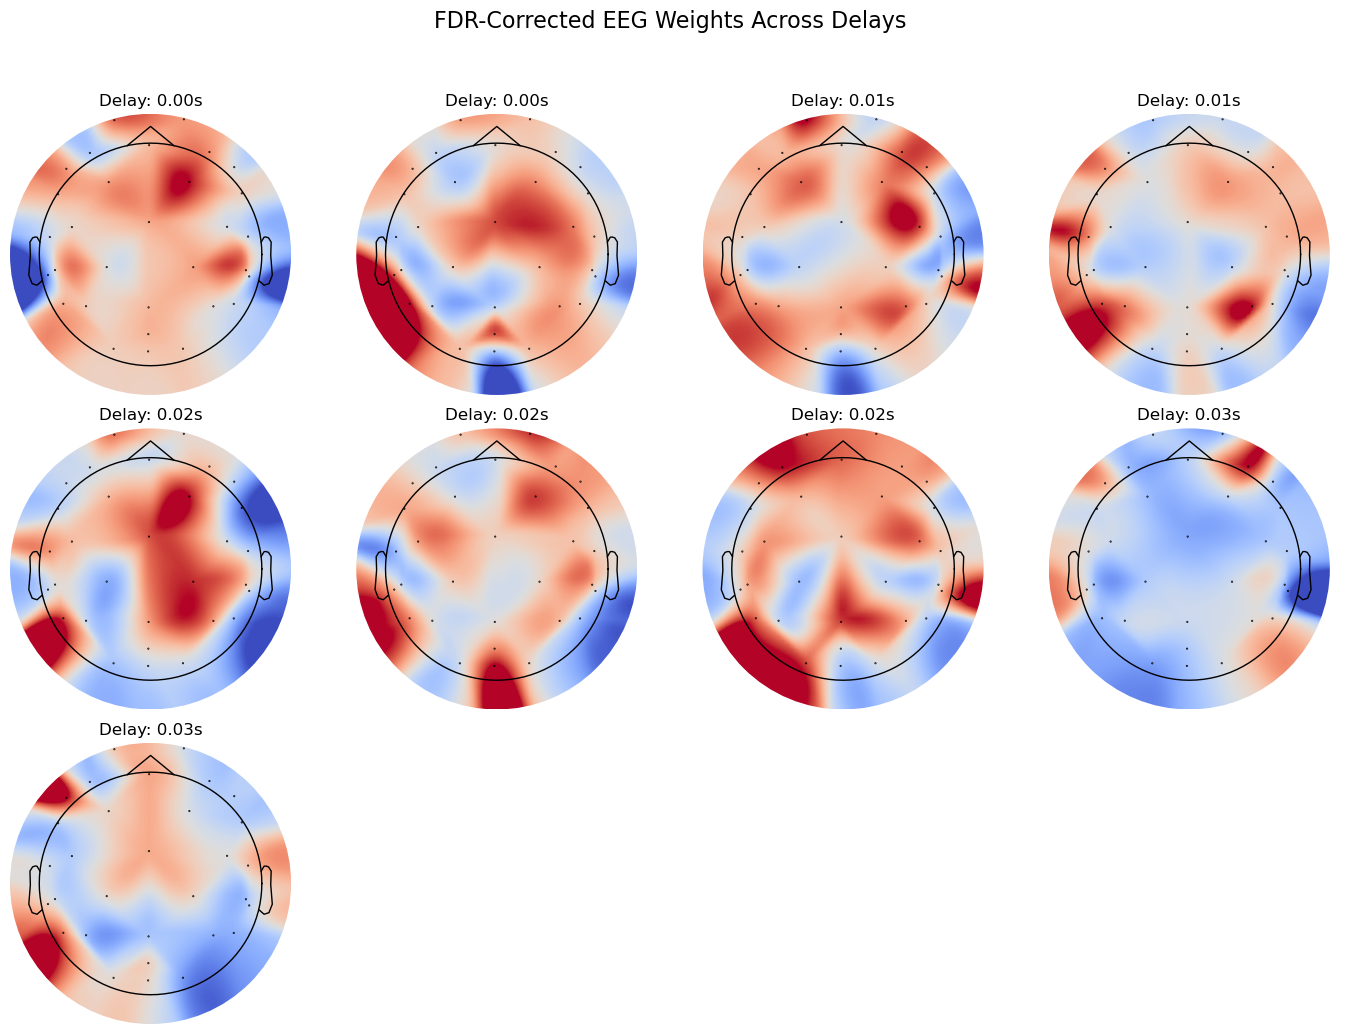

In [78]:
# Delay setup (make sure `delays` and fs are defined)
delay_times = [d / fs for d in range(n_delays)]  # in seconds

# Prepare valid EEG channel positions
valid_idx = []
valid_pos = []
for i in range(n_channels):
    loc = raw.info['chs'][i]['loc'][:2]
    if not np.any(np.isnan(loc)):
        valid_idx.append(i)
        valid_pos.append(loc)
valid_pos = np.array(valid_pos)

# Create grid layout
n_cols = 4
n_rows = int(np.ceil(n_delays / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3.5 * n_rows))

for i, ax in enumerate(axs.flat):
    if i < n_delays:
        # Get FDR-corrected weights for this delay (sum across bands)
        delay_weights = np.abs(coefs_3d_fdr[:, :, i]).sum(axis=1)

        # Filter valid channels
        weights_valid = [delay_weights[j] for j in valid_idx]

        plot_topomap(weights_valid, valid_pos, axes=ax, contours=0, cmap="coolwarm", show=False)
        ax.set_title(f"Delay: {delay_times[i]:.2f}s")
    else:
        ax.axis("off")

fig.suptitle("FDR-Corrected EEG Weights Across Delays", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Matplotlib Animation Across Delays



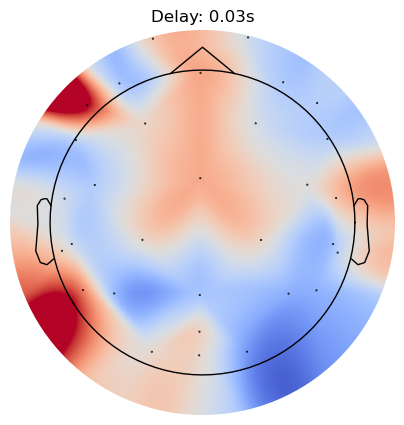

In [79]:
import matplotlib.pyplot as plt
from mne.viz import plot_topomap
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Prepare topomap data
topomap_series = []
for i in range(n_delays):
    weights = np.abs(coefs_3d_fdr[:, :, i]).sum(axis=1)
    topomap_series.append([weights[j] for j in valid_idx])

# Setup figure
fig, ax = plt.subplots(figsize=(5, 5))

def update(frame):
    ax.clear()
    im, _ = plot_topomap(topomap_series[frame], valid_pos, axes=ax,
                         contours=0, cmap="coolwarm", show=False)
    ax.set_title(f"Delay: {delay_times[frame]:.2f}s")
    return [im]

ani = FuncAnimation(fig, update, frames=n_delays, interval=800, blit=True)

plt.rcParams["animation.html"] = "jshtml"
HTML(ani.to_jshtml())  # ✅ only this renders in notebook


✅ Most predictive feature: F4 — Beta1


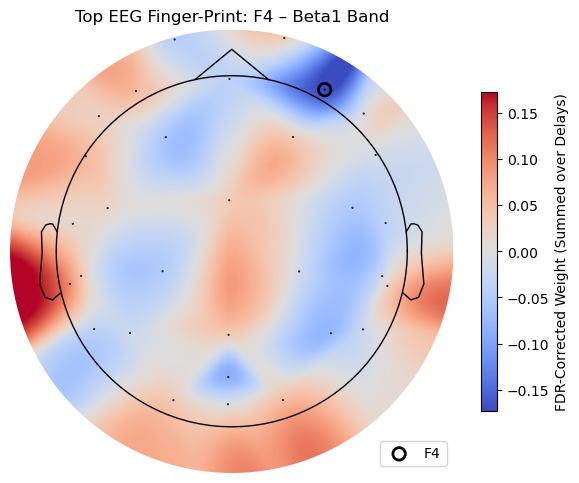

In [80]:
from mne.viz import plot_topomap
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Identify top electrode × band
coefs_3d_fdr = mean_coefs_fdr.reshape(n_channels, n_bands, n_delays)
contrib_map = np.abs(coefs_3d_fdr).sum(axis=2)
top_ch_idx, top_band_idx = np.unravel_index(np.argmax(contrib_map), contrib_map.shape)
top_band_name = band_labels[top_band_idx]
top_ch_name = raw.ch_names[top_ch_idx]

print(f"✅ Most predictive feature: {top_ch_name} — {top_band_name}")

# Step 2: Prepare weights and positions
weights = coefs_3d_fdr[:, top_band_idx, :].sum(axis=1)
valid_idx = []
valid_pos = []
valid_weights = []
for i in range(n_channels):
    pos = raw.info['chs'][i]['loc'][:2]
    if not np.any(np.isnan(pos)):
        valid_idx.append(i)
        valid_pos.append(pos)
        valid_weights.append(weights[i])

valid_pos = np.array(valid_pos)

# Get position of top electrode
top_plot_idx = valid_idx.index(top_ch_idx)
top_plot_pos = valid_pos[top_plot_idx]

# Step 3: Plot with circle on top electrode
fig, ax = plt.subplots(figsize=(6, 5))
im, _ = plot_topomap(valid_weights, valid_pos, axes=ax, cmap="coolwarm", contours=0, show=False)
ax.scatter(*top_plot_pos, color='black', s=80, facecolors='none', linewidths=2, label=f'{top_ch_name}')
plt.colorbar(im, ax=ax, shrink=0.7, label='FDR-Corrected Weight (Summed over Delays)')
ax.set_title(f"Top EEG Finger-Print: {top_ch_name} – {top_band_name} Band")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


## Smoothed + Normalized PDA vs. EEG (Top Feature)

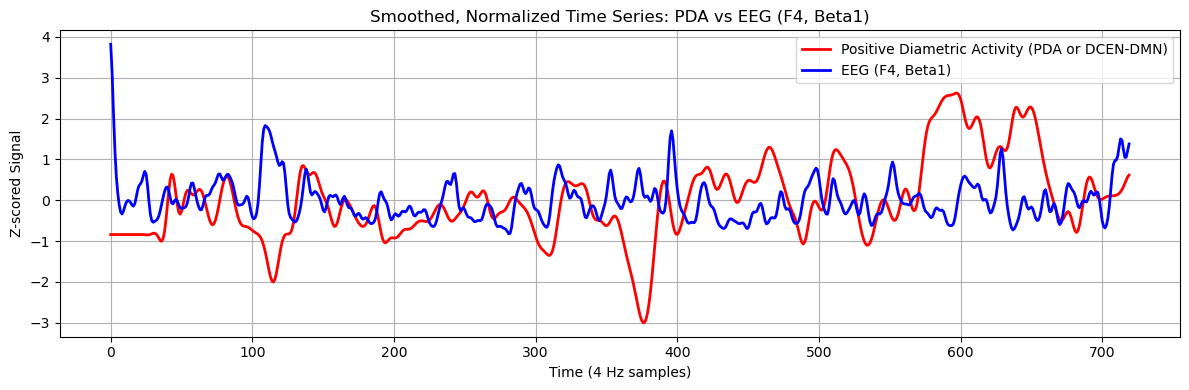

In [81]:
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# Step 1: Extract EEG time series for top electrode × band across all delays
eeg_feature_idx = top_ch_idx * n_bands * n_delays + top_band_idx * n_delays
eeg_time_series = X_with_delays[:, eeg_feature_idx:eeg_feature_idx + n_delays].sum(axis=1)

# Step 2: Normalize (z-score)
eeg_z = zscore(eeg_time_series)
pda_z = zscore(y_with_delays)

# Step 3: Smooth both with a Gaussian filter
sigma = 2  # adjust for smoothing extent (e.g., sigma=2 = half-second if fs=4 Hz)
eeg_smooth = gaussian_filter1d(eeg_z, sigma=sigma)
pda_smooth = gaussian_filter1d(pda_z, sigma=sigma)

# Step 4: Plot
plt.figure(figsize=(12, 4))
plt.plot(pda_smooth, label='Positive Diametric Activity (PDA or DCEN-DMN)', color='red', linewidth=2)
plt.plot(eeg_smooth, label=f'EEG ({top_ch_name}, {top_band_name})', color='blue', linewidth=2)
plt.title(f'Smoothed, Normalized Time Series: PDA vs EEG ({top_ch_name}, {top_band_name})')
plt.xlabel('Time (4 Hz samples)')
plt.ylabel('Z-scored Signal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


'../figures/EFP_summary_plot_with_caption.png'

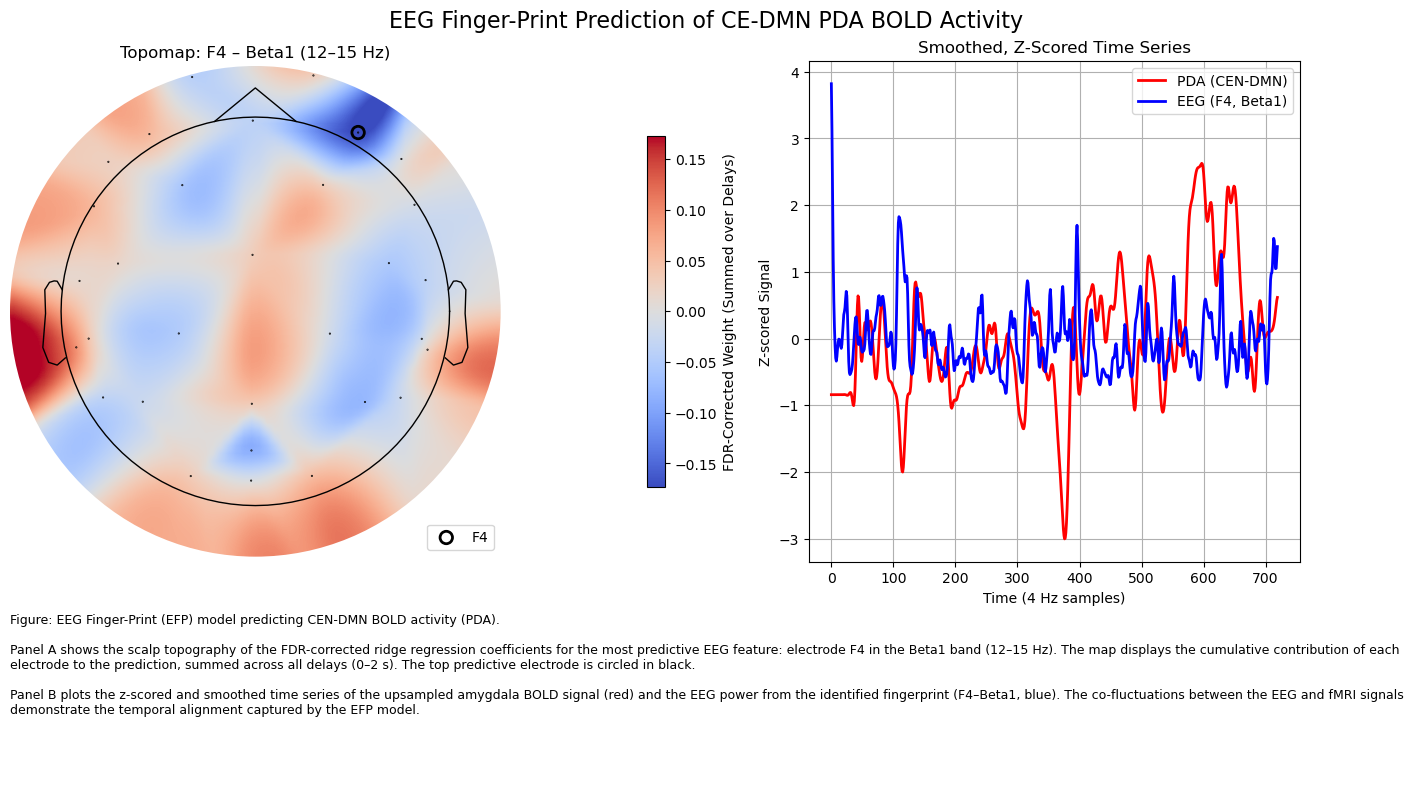

In [82]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mne.viz import plot_topomap
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore

# Define frequency ranges
band_ranges_hz = {
    "Delta": (1, 4),
    "Theta": (4, 7),
    "Alpha1": (7, 9),
    "Alpha2": (9, 12),
    "Beta1": (12, 15),
    "Beta2": (15, 20),
    "Beta3": (20, 25),
    "Beta4": (25, 30),
    "Gamma1": (30, 35),
    "Gamma2": (35, 40)
}

# Figure layout: 2 rows (topo + timeseries, caption)
fig = plt.figure(figsize=(14, 8), constrained_layout=True)
gs = GridSpec(2, 2, figure=fig, height_ratios=[2, 0.75])

# Panel A: Topomap
ax1 = fig.add_subplot(gs[0, 0])
im, _ = plot_topomap(valid_weights, valid_pos, axes=ax1, cmap="coolwarm", contours=0, show=False)
ax1.scatter(*top_plot_pos, color='black', s=80, facecolors='none', linewidths=2, label=f'{top_ch_name}')
f_range = band_ranges_hz.get(top_band_name, ("?", "?"))
cbar = plt.colorbar(im, ax=ax1, shrink=0.7, label='FDR-Corrected Weight (Summed over Delays)')
ax1.set_title(f"Topomap: {top_ch_name} – {top_band_name} ({f_range[0]}–{f_range[1]} Hz)")
ax1.legend(loc="lower right")

# Panel B: Time Series
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(pda_smooth, label='PDA (CEN-DMN)', color='red', linewidth=2)
ax2.plot(eeg_smooth, label=f'EEG ({top_ch_name}, {top_band_name})', color='blue', linewidth=2)
ax2.set_title("Smoothed, Z-Scored Time Series")
ax2.set_xlabel("Time (4 Hz samples)")
ax2.set_ylabel("Z-scored Signal")
ax2.legend()
ax2.grid(True)

# Panel C: Caption
caption = (
    f"Figure: EEG Finger-Print (EFP) model predicting CEN-DMN BOLD activity (PDA).\n\n"
    f"Panel A shows the scalp topography of the FDR-corrected ridge regression coefficients for the most predictive EEG feature: "
    f"electrode {top_ch_name} in the {top_band_name} band ({f_range[0]}–{f_range[1]} Hz). The map displays the cumulative contribution "
    "of each electrode to the prediction, summed across all delays (0–2 s). The top predictive electrode is circled in black.\n\n"
    "Panel B plots the z-scored and smoothed time series of the upsampled amygdala BOLD signal (red) and the EEG power from the identified "
    f"fingerprint ({top_ch_name}–{top_band_name}, blue). The co-fluctuations between the EEG and fMRI signals demonstrate the temporal alignment "
    "captured by the EFP model."
)

ax_caption = fig.add_subplot(gs[1, :])
ax_caption.axis("off")
ax_caption.text(0, 1, caption, ha='left', va='top', wrap=True, fontsize=9)

# Super title and save
fig.suptitle("EEG Finger-Print Prediction of CE-DMN PDA BOLD Activity", fontsize=16)
plt.savefig("../figures/EFP_summary_plot_with_caption.png", dpi=300)
"../figures/EFP_summary_plot_with_caption.png"
